<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/P0_BigMonksDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frailejon Detection (a.k.a "Big Monks Detection")


En este cuadernos continuaremos con nuestra aproximación a las redes neuronales de la mano con la clasificación de imagenes.

Usted debe construir una red neuronal para detectar automáticamente plantas nativas (frailejones) sobre imagenes aerea páramo de Chingaza y Cruz Verde.

**Business Problem Framming**: Este caso de estudio hace parte de un proyecto de Ingeniería que busca preservar y monitorizar el ecosistema del páramo, de gran importancia por su potencial hídrico, mediante la propuesta de una metodología para la reconstrucción del ecosistema en zonas de baja densidad de poblaciones de la especia _Espeletia_.

## Data
Input:

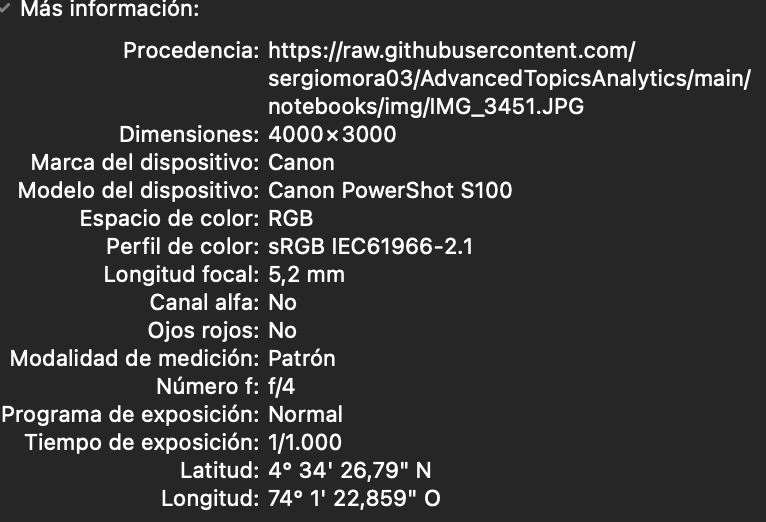

Output:
1. probability that it is a Big Monk.
2. Calculate Big Monks density

## Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".


## Requirements

- The project must be carried out in groups of 4 people.
- Use clear and rigorous procedures.
- The delivery of the project is on September 6th, 2024, 11:59 pm, through email with Github link.
- No projects will be received after the delivery time or by any other means than the one established.

## Suggestions

* Use an hyperparameter optimization framework, you can also make grid optimziation or bayesian optimization. Bonus with use:  [Optuna - A hyperparameter optimization framework](https://optuna.org/)
* Remember cualitative analysis with validation image: `IMG_3451.JPG`
* Estimate density for each Big Monks population detected. Bonus with: [Gaussian Mixture Models](https://nbviewer.jupyter.org/github/sergiomora03/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb)

## Acknowledgements
We thank Professor Camilo Franco, Ph.D.

In [ ]:
!pip install -q optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.layers import ELU, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam, Ftrl, Lion
from keras import regularizers
import optuna
from optuna.samplers import TPESampler

from ImportImagenesURL import import_imagenes

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
CT_xn, CT_y, CT_x22 = import_imagenes()
CT_xn.shape, CT_y.shape, CT_x22.shape

((14700, 250), (1, 250), (250, 70, 70, 3))

In [ ]:
print('How many photos are there with frailejones?')
CT_y_list = pd.Series(CT_y[0])
CT_y_list.value_counts()

,count
0,145
1,105


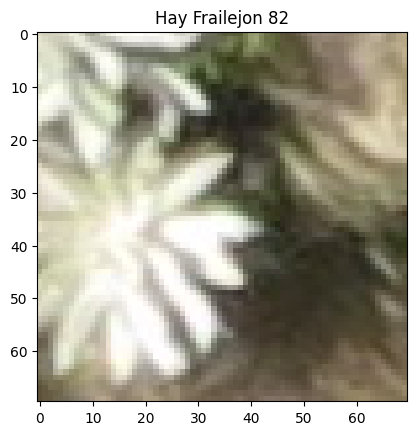

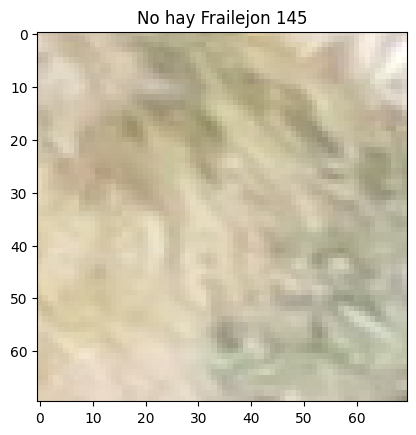

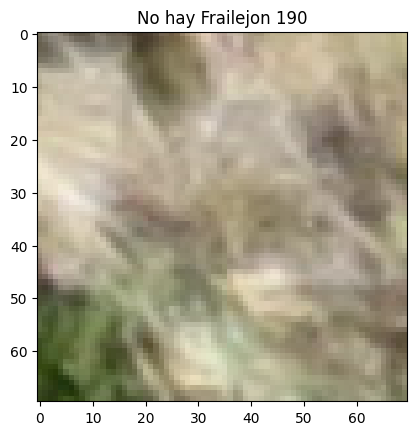

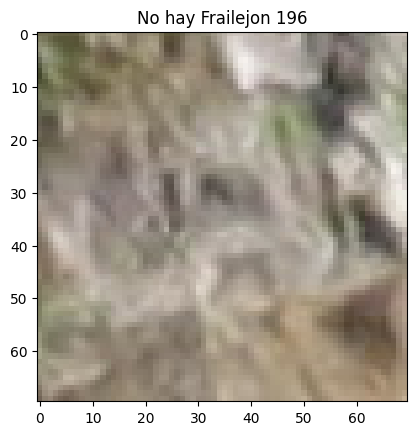

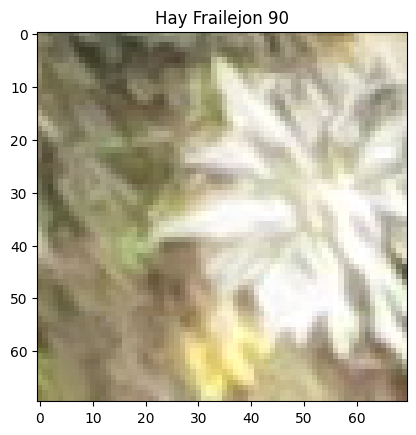

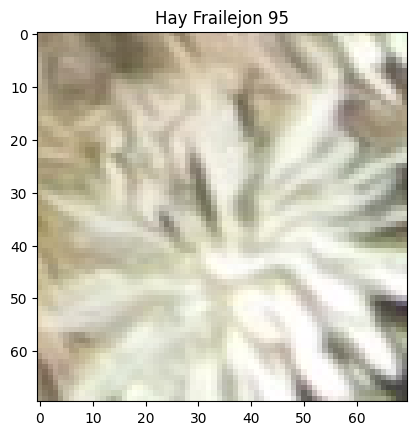

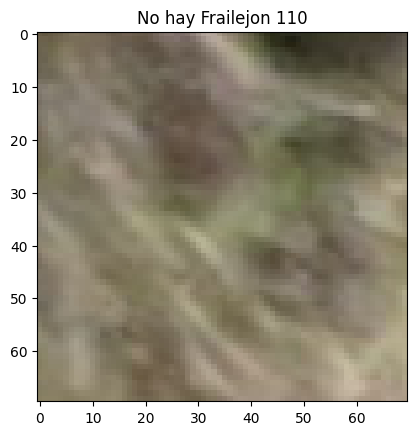

In [ ]:
def muestra_image(i):
    '''
        Esta funcion grafica i imagenes aleatoriamente
    '''
    for _ in range(i):
        # Seleccionar una imagen aleatoria (0 a 249 imagenes)
        indice_aleatorio = np.random.randint(0, CT_xn.shape[1])
        imagen_elegida = CT_x22[indice_aleatorio]
        nombre_imagen = CT_y[0][indice_aleatorio]

        if nombre_imagen == 1:
            tit = f'Hay Frailejon {indice_aleatorio}'
        else:
            tit = f'No hay Frailejon {indice_aleatorio}'

        plt.imshow(imagen_elegida)
        plt.title(tit)
        plt.show()

muestra_image(7)  # Agregar

In [ ]:
# train, test
train_X, test_X, train_Y, test_Y = train_test_split(CT_xn.T, CT_y_list, test_size = 0.2)
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Test data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (200, 14700) (200,)
Test data shape:  (50, 14700) (50,)


Notas:

Se tiene 250 imagenes. <br>
Solamente 105 imagenes contienen frailejones, 145 no contienen frailejones. <br>
Si hacemos train test - 200 seran para entrenamiento y 50 testeo (aun no usado).

## Conjunto de datos

Para el entrenamiento de la red neuronal, se usará el archivo `data_F`. Debe divirse en dos grupos, conjunto de entrenamiento (CE) y conjunto de validación (CV).

Adicionalmente, fuera de las métricas del modelo, se requiere que extraiga un análisis cualitativo con la imagen `IMG_3451.JPG`, donde muestre los Frilejones detectados en el area del páramo tomado por la fotografía.

Recuerde, primero, cargamos el conjunto de datos sobre el que se va a trabajar. El siguiente código va a cargar un conjunto de datos `X` e `Y` donde `Y`es una variable binaria.

## Caso Aplicado

### Cálculo de cantidad de Frilejones

vamos a aplicar al menos 5 modelos, se estiman los siguientes valores como resultado del entrenamiento:



*   Sencilla --> 0.88
*   Multi-capa --> 0.95
*  Convolucional --> 0.95
*  Convolucional + VGG16 --> 0.99



1. Implementa una red neuronal sencilla.

In [ ]:
### Inputs (dim de datos)
input_data = CT_xn.shape[0]
### Neuronas en la capa oculta (unica capa oculta)
num_neurons = 3
### Salida
num_outputs = 1
### Taza de aprendizaje
learning_rate=0.1

In [ ]:
### Definir el modelo
model = Sequential()
model.add(Dense(num_neurons, activation='relu', input_shape=(input_data,)))
model.add(Dense(num_outputs, activation='sigmoid'))
print('Structure of the neural network')
print(model.summary())

Structure of the neural network


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3)                   │          44,103 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,107 (172.29 KB)

 Trainable params: 44,107 (172.29 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
### Definir compilador

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['binary_accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate),
#               metrics=['auc'])

### Ajustar el modelo
model.fit(CT_xn.T, CT_y_list,
          epochs=500,
          batch_size=None,
          validation_split=0.05,
          verbose=False)

In [ ]:
scores = model.evaluate(CT_xn.T, CT_y_list)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.2964 - loss: 0.7467     
compile_metrics: 58.00%


Usamos Optuna para mejorar la Red neuronal

In [ ]:
def objective(trial):

    """
    Function to optimize hyperparameter searching with Optuna for a Neural Network.

    Args:
        trial (optuna.Trial): The Optuna trial object for hyperparameter search.

    Returns:
        float: The binary accuracy score of the trained model.
    """

    # Define the search space
    units = trial.suggest_int('units', 32, 700)
    activation = trial.suggest_categorical('activation', ['relu', 'relu', 'tanh', 'sigmoid'])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'Ftrl', 'Lion'])
    epochs = trial.suggest_int('epochs', 10, 100)
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
    optimizers = {
        "Adam": Adam(learning_rate=lr),
        "RMSprop": RMSprop(learning_rate=lr),
        "Ftrl": Ftrl(learning_rate=lr),
        "Lion": Lion(learning_rate=lr),
    }
    optimizer = optimizers[optimizer_name]

    ### Define the model
    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(input_data,)))
    model.add(Dense(num_outputs, activation='sigmoid'))

    ### Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['binary_accuracy'])

    # model.compile(loss='binary_crossentropy',
    #               optimizer=tf.keras.optimizers.Adam(learning_rate),
    #               metrics=['auc'])

    ### Fit the model
    model.fit(CT_xn.T, CT_y_list,
              epochs=epochs,
              batch_size=None,
              validation_split=0.1,
              verbose=True)

    ### Evaluate the model and return the binary accuracy score
    _, binary_accuracy = model.evaluate(CT_xn.T, CT_y_list,)

    return binary_accuracy

In [ ]:
study_snn = optuna.create_study(study_name="model_simple_neural_network",
                                direction="maximize",
                                pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
                                sampler=TPESampler())
study_snn.optimize(objective, n_trials=100)

[I 2024-09-02 18:55:58,521] A new study created in memory with name: model_simple_neural_network


Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - binary_accuracy: 0.4854 - loss: 0.7318 - val_binary_accuracy: 0.8800 - val_loss: 0.6121
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - binary_accuracy: 0.4896 - loss: 0.7207 - val_binary_accuracy: 0.9200 - val_loss: 0.5738
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - binary_accuracy: 0.5772 - loss: 0.6979 - val_binary_accuracy: 0.6400 - val_loss: 0.6666
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - binary_accuracy: 0.6421 - loss: 0.6574 - val_binary_accuracy: 0.4000 - val_loss: 0.7276
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - binary_accuracy: 0.5932 - loss: 0.6406 - val_binary_accuracy: 0.5600 - val_loss: 0.6486
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - binary_accuracy: 0.6921 - loss: 0.6225 - val_binary_accuracy: 0.9600 - val_loss: 0.5625
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - binary_accuracy: 0.7387 - loss: 0.5998 - val_binary_accuracy: 0.9600 - val_loss: 0.5342
Epoch 8/80
8/8 ━━━━━

[I 2024-09-02 18:57:40,992] Trial 0 finished with value: 0.8999999761581421 and parameters: {'units': 566, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 80, 'lr': 1.154046067818305e-06}. Best is trial 0 with value: 0.8999999761581421.


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - binary_accuracy: 0.4914 - loss: 12.1756 - val_binary_accuracy: 1.0000 - val_loss: 0.0067
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - binary_accuracy: 0.5269 - loss: 2.0800 - val_binary_accuracy: 1.0000 - val_loss: 0.0034
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - binary_accuracy: 0.5556 - loss: 1.9615 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.8599
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - binary_accuracy: 0.5080 - loss: 1.5660 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.6470
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.5198 - loss: 1.7408 - val_binary_accuracy: 1.0000 - val_loss: 0.0066
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - binary_accuracy: 0.6091 - loss: 1.2154 - val_binary_accuracy: 1.0000 - val_loss: 0.0403
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.5208 - loss: 1.2618 - val_binary_accuracy: 1.0000 - val_loss: 0.0037
Epoch 8/20
8/8 ━━

[I 2024-09-02 18:57:57,946] Trial 1 finished with value: 0.5600000023841858 and parameters: {'units': 421, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 20, 'lr': 0.0005650340361880695}. Best is trial 0 with value: 0.8999999761581421.


Epoch 1/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - binary_accuracy: 0.4353 - loss: 2.3653 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.4135
Epoch 2/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5639 - loss: 0.9522 - val_binary_accuracy: 1.0000 - val_loss: 0.0143
Epoch 3/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.6248 - loss: 0.9430 - val_binary_accuracy: 1.0000 - val_loss: 0.0596
Epoch 4/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.6562 - loss: 0.6329 - val_binary_accuracy: 1.0000 - val_loss: 0.0120
Epoch 5/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.6210 - loss: 0.8032 - val_binary_accuracy: 1.0000 - val_loss: 0.0112
Epoch 6/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.6534 - loss: 0.7710 - val_binary_accuracy: 0.2400 - val_loss: 0.9941
Epoch 7/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - binary_accuracy: 0.6415 - loss: 0.6439 - val_binary_accuracy: 1.0000 - val_loss: 0.0356
Epoch 8/91
8/8 ━━━━━━━━

[I 2024-09-02 18:59:03,160] Trial 2 finished with value: 0.9599999785423279 and parameters: {'units': 428, 'activation': 'tanh', 'optimizer': 'RMSprop', 'epochs': 91, 'lr': 3.2107941328357604e-05}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - binary_accuracy: 0.5355 - loss: 6.7410 - val_binary_accuracy: 0.0000e+00 - val_loss: 6.0351
Epoch 2/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.4611 - loss: 2.6582 - val_binary_accuracy: 0.0000e+00 - val_loss: 5.9560
Epoch 3/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.4294 - loss: 2.5630 - val_binary_accuracy: 1.0000 - val_loss: 0.2404
Epoch 4/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.4629 - loss: 1.4551 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.9102
Epoch 5/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.4777 - loss: 1.2492 - val_binary_accuracy: 1.0000 - val_loss: 0.3041
Epoch 6/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.6117 - loss: 0.6566 - val_binary_accuracy: 1.0000 - val_loss: 0.0924
Epoch 7/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.6713 - loss: 0.7647 - val_binary_accuracy: 1.0000 - val_loss: 0.2226
Epoch 8/56
8/8 

[I 2024-09-02 18:59:22,492] Trial 3 finished with value: 0.9200000166893005 and parameters: {'units': 200, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 56, 'lr': 0.0012012639822157715}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - binary_accuracy: 0.5569 - loss: 0.7237 - val_binary_accuracy: 1.0000 - val_loss: 0.6914
Epoch 2/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - binary_accuracy: 0.5143 - loss: 0.6932 - val_binary_accuracy: 1.0000 - val_loss: 0.6924
Epoch 3/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - binary_accuracy: 0.5138 - loss: 0.6932 - val_binary_accuracy: 0.4000 - val_loss: 0.6932
Epoch 4/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.5422 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6926
Epoch 5/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - binary_accuracy: 0.5472 - loss: 0.6931 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6934
Epoch 6/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - binary_accuracy: 0.4927 - loss: 0.6930 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6943
Epoch 7/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.4725 - loss: 0.6930 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6935
Epoch 8/69
8

[I 2024-09-02 19:00:42,159] Trial 4 finished with value: 0.4399999976158142 and parameters: {'units': 371, 'activation': 'tanh', 'optimizer': 'Ftrl', 'epochs': 69, 'lr': 1.2819883407052885e-05}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - binary_accuracy: 0.5523 - loss: 100.5026 - val_binary_accuracy: 0.0000e+00 - val_loss: 146.7878
Epoch 2/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.5003 - loss: 47.0606 - val_binary_accuracy: 1.0000 - val_loss: 2.5213e-07
Epoch 3/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.4278 - loss: 8.3642 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7462
Epoch 4/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.4167 - loss: 1.0148 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7462
Epoch 5/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.4720 - loss: 0.6960 - val_binary_accuracy: 1.0000 - val_loss: 0.6931
Epoch 6/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.5267 - loss: 0.8265 - val_binary_accuracy: 1.0000 - val_loss: 0.6931
Epoch 7/56
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.5878 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6676
Epoch 

[I 2024-09-02 19:00:54,045] Trial 5 finished with value: 0.5600000023841858 and parameters: {'units': 73, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 56, 'lr': 0.025844410198688952}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - binary_accuracy: 0.4522 - loss: 0.7795 - val_binary_accuracy: 0.6000 - val_loss: 0.6858
Epoch 2/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.5070 - loss: 0.7083 - val_binary_accuracy: 0.0800 - val_loss: 0.8620
Epoch 3/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.4907 - loss: 0.6836 - val_binary_accuracy: 0.0800 - val_loss: 0.8617
Epoch 4/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - binary_accuracy: 0.5122 - loss: 0.6719 - val_binary_accuracy: 0.2000 - val_loss: 0.7693
Epoch 5/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - binary_accuracy: 0.6057 - loss: 0.6626 - val_binary_accuracy: 0.9600 - val_loss: 0.5493
Epoch 6/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.6141 - loss: 0.6738 - val_binary_accuracy: 0.7200 - val_loss: 0.6296
Epoch 7/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.5595 - loss: 0.6586 - val_binary_accuracy: 0.0800 - val_loss: 0.8573
Epoch 8/26
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:01:13,176] Trial 6 finished with value: 0.7599999904632568 and parameters: {'units': 345, 'activation': 'relu', 'optimizer': 'Adam', 'epochs': 26, 'lr': 2.909213997464698e-06}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - binary_accuracy: 0.5412 - loss: 2.4720 - val_binary_accuracy: 1.0000 - val_loss: 0.0792
Epoch 2/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.5435 - loss: 0.9256 - val_binary_accuracy: 1.0000 - val_loss: 0.3064
Epoch 3/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.5475 - loss: 0.7373 - val_binary_accuracy: 1.0000 - val_loss: 0.4634
Epoch 4/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.4865 - loss: 0.7208 - val_binary_accuracy: 1.0000 - val_loss: 0.4964
Epoch 5/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.5317 - loss: 0.6838 - val_binary_accuracy: 1.0000 - val_loss: 0.4306
Epoch 6/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.5117 - loss: 0.6781 - val_binary_accuracy: 1.0000 - val_loss: 0.2362
Epoch 7/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.5233 - loss: 0.7678 - val_binary_accuracy: 1.0000 - val_loss: 0.3113
Epoch 8/23
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:01:20,812] Trial 7 finished with value: 0.6200000047683716 and parameters: {'units': 140, 'activation': 'tanh', 'optimizer': 'Adam', 'epochs': 23, 'lr': 0.00019414386541985213}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - binary_accuracy: 0.5134 - loss: 1355.5405 - val_binary_accuracy: 0.0000e+00 - val_loss: 140.4825
Epoch 2/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - binary_accuracy: 0.5289 - loss: 53.3598 - val_binary_accuracy: 1.0000 - val_loss: 0.0039
Epoch 3/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - binary_accuracy: 0.6120 - loss: 2.5612 - val_binary_accuracy: 1.0000 - val_loss: 0.2848
Epoch 4/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - binary_accuracy: 0.6164 - loss: 0.7089 - val_binary_accuracy: 1.0000 - val_loss: 0.0130
Epoch 5/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - binary_accuracy: 0.5724 - loss: 1.8386 - val_binary_accuracy: 1.0000 - val_loss: 0.6495
Epoch 6/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - binary_accuracy: 0.6087 - loss: 0.6771 - val_binary_accuracy: 0.0000e+00 - val_loss: 8.7225
Epoch 7/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - binary_accuracy: 0.5455 - loss: 2.4105 - val_binary_accuracy: 1.0000 - val_loss: 0.6207
Epoch 

[I 2024-09-02 19:02:27,858] Trial 8 finished with value: 0.5600000023841858 and parameters: {'units': 603, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 38, 'lr': 0.021210353573829}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/58
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - binary_accuracy: 0.4760 - loss: 1.4184 - val_binary_accuracy: 1.0000 - val_loss: 0.2272
Epoch 2/58
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.5128 - loss: 0.9385 - val_binary_accuracy: 1.0000 - val_loss: 0.2805
Epoch 3/58
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.5958 - loss: 0.7557 - val_binary_accuracy: 1.0000 - val_loss: 0.1734
Epoch 4/58
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.5960 - loss: 0.8732 - val_binary_accuracy: 1.0000 - val_loss: 0.2299
Epoch 5/58
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.6124 - loss: 0.7383 - val_binary_accuracy: 1.0000 - val_loss: 0.1392
Epoch 6/58
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.6438 - loss: 0.7998 - val_binary_accuracy: 1.0000 - val_loss: 0.1979
Epoch 7/58
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.6200 - loss: 0.7281 - val_binary_accuracy: 1.0000 - val_loss: 0.3099
Epoch 8/58
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:02:53,079] Trial 9 finished with value: 0.8199999928474426 and parameters: {'units': 145, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 58, 'lr': 4.66203799609188e-05}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - binary_accuracy: 0.5379 - loss: 0.6929 - val_binary_accuracy: 1.0000 - val_loss: 0.6922
Epoch 2/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - binary_accuracy: 0.5215 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6893
Epoch 3/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - binary_accuracy: 0.5323 - loss: 0.6929 - val_binary_accuracy: 1.0000 - val_loss: 0.6901
Epoch 4/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - binary_accuracy: 0.5351 - loss: 0.6929 - val_binary_accuracy: 1.0000 - val_loss: 0.6878
Epoch 5/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - binary_accuracy: 0.5260 - loss: 0.6929 - val_binary_accuracy: 1.0000 - val_loss: 0.6885
Epoch 6/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - binary_accuracy: 0.5303 - loss: 0.6929 - val_binary_accuracy: 1.0000 - val_loss: 0.6892
Epoch 7/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - binary_accuracy: 0.5139 - loss: 0.6930 - val_binary_accuracy: 1.0000 - val_loss: 0.6899
Epoch 8/99
8/8 ━━━━━

[I 2024-09-02 19:08:30,759] Trial 10 finished with value: 0.5600000023841858 and parameters: {'units': 698, 'activation': 'sigmoid', 'optimizer': 'Ftrl', 'epochs': 99, 'lr': 2.287144248043027e-05}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - binary_accuracy: 0.5131 - loss: 21.7446 - val_binary_accuracy: 1.0000 - val_loss: 3.4812e-14
Epoch 2/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.4445 - loss: 24.3468 - val_binary_accuracy: 1.0000 - val_loss: 2.8559e-14
Epoch 3/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - binary_accuracy: 0.5536 - loss: 15.9012 - val_binary_accuracy: 1.0000 - val_loss: 1.4515e-13
Epoch 4/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - binary_accuracy: 0.5405 - loss: 13.3504 - val_binary_accuracy: 0.0000e+00 - val_loss: 20.0509
Epoch 5/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - binary_accuracy: 0.4771 - loss: 6.1537 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.9459
Epoch 6/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5317 - loss: 1.1212 - val_binary_accuracy: 1.0000 - val_loss: 0.1534
Epoch 7/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.6400 - loss: 0.7204 - val_binary_accuracy: 0.9200 - val_loss: 0.4966
E

[I 2024-09-02 19:09:29,073] Trial 11 finished with value: 0.9399999976158142 and parameters: {'units': 261, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 99, 'lr': 0.0021494250241999133}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - binary_accuracy: 0.5316 - loss: 35.5281 - val_binary_accuracy: 0.0000e+00 - val_loss: 89.8703
Epoch 2/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.4428 - loss: 31.7643 - val_binary_accuracy: 0.8800 - val_loss: 0.6941
Epoch 3/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.5463 - loss: 0.6931 - val_binary_accuracy: 0.9600 - val_loss: 0.6874
Epoch 4/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - binary_accuracy: 0.4972 - loss: 0.6933 - val_binary_accuracy: 0.9600 - val_loss: 0.6841
Epoch 5/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.5318 - loss: 0.6924 - val_binary_accuracy: 1.0000 - val_loss: 0.6710
Epoch 6/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.5204 - loss: 0.6923 - val_binary_accuracy: 1.0000 - val_loss: 0.6580
Epoch 7/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.5567 - loss: 0.6897 - val_binary_accuracy: 1.0000 - val_loss: 0.6484
Epoch 8/95
8/8 ━━━━━

[I 2024-09-02 19:10:27,637] Trial 12 finished with value: 0.5600000023841858 and parameters: {'units': 265, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 95, 'lr': 0.003341330722780697}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/83
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - binary_accuracy: 0.5892 - loss: 3.7540 - val_binary_accuracy: 0.0000e+00 - val_loss: 6.2212
Epoch 2/83
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.5031 - loss: 2.2104 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.1293
Epoch 3/83
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - binary_accuracy: 0.6009 - loss: 1.1520 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.6419
Epoch 4/83
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - binary_accuracy: 0.5026 - loss: 1.0801 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.5998
Epoch 5/83
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.4884 - loss: 1.4122 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.9828
Epoch 6/83
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - binary_accuracy: 0.5405 - loss: 0.9186 - val_binary_accuracy: 1.0000 - val_loss: 0.0655
Epoch 7/83
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - binary_accuracy: 0.5120 - loss: 1.0517 - val_binary_accuracy: 1.0000 - val_loss: 0.0311
Epoch 

[I 2024-09-02 19:11:45,813] Trial 13 finished with value: 0.7599999904632568 and parameters: {'units': 478, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 83, 'lr': 0.00013127521025702867}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - binary_accuracy: 0.4461 - loss: 13.7386 - val_binary_accuracy: 0.0000e+00 - val_loss: 14.9101
Epoch 2/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - binary_accuracy: 0.5118 - loss: 5.0565 - val_binary_accuracy: 1.0000 - val_loss: 0.0206
Epoch 3/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5517 - loss: 1.3019 - val_binary_accuracy: 0.9600 - val_loss: 0.6862
Epoch 4/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5286 - loss: 0.6907 - val_binary_accuracy: 1.0000 - val_loss: 0.6725
Epoch 5/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5927 - loss: 0.6828 - val_binary_accuracy: 1.0000 - val_loss: 0.6657
Epoch 6/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5310 - loss: 0.6874 - val_binary_accuracy: 1.0000 - val_loss: 0.6556
Epoch 7/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - binary_accuracy: 0.5151 - loss: 0.9100 - val_binary_accuracy: 1.0000 - val_loss: 0.6457
Epoch 8/84
8/8 ━━━━━━

[I 2024-09-02 19:12:33,193] Trial 14 finished with value: 0.5600000023841858 and parameters: {'units': 288, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 84, 'lr': 0.003472812904959071}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - binary_accuracy: 0.5170 - loss: 8676.0850 - val_binary_accuracy: 1.0000 - val_loss: 1.6577e-19
Epoch 2/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5167 - loss: 78.3794 - val_binary_accuracy: 1.0000 - val_loss: 0.5377
Epoch 3/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5424 - loss: 10.6220 - val_binary_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.4678 - loss: 44.2490 - val_binary_accuracy: 0.9200 - val_loss: 0.6889
Epoch 5/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.5752 - loss: 0.6922 - val_binary_accuracy: 1.0000 - val_loss: 0.6014
Epoch 6/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.5160 - loss: 0.6934 - val_binary_accuracy: 1.0000 - val_loss: 0.6690
Epoch 7/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5429 - loss: 0.6912 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7274
Epoch 8/7

[I 2024-09-02 19:13:30,490] Trial 15 finished with value: 0.5600000023841858 and parameters: {'units': 492, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 73, 'lr': 0.06810036273205171}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - binary_accuracy: 0.5632 - loss: 0.7039 - val_binary_accuracy: 0.4000 - val_loss: 0.7575
Epoch 2/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.6064 - loss: 0.6569 - val_binary_accuracy: 0.9200 - val_loss: 0.5014
Epoch 3/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.5592 - loss: 0.6911 - val_binary_accuracy: 0.7600 - val_loss: 0.6280
Epoch 4/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - binary_accuracy: 0.6142 - loss: 0.6427 - val_binary_accuracy: 0.2000 - val_loss: 0.8363
Epoch 5/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.5165 - loss: 0.6643 - val_binary_accuracy: 0.6800 - val_loss: 0.6668
Epoch 6/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.6179 - loss: 0.6265 - val_binary_accuracy: 0.8000 - val_loss: 0.6077
Epoch 7/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - binary_accuracy: 0.6198 - loss: 0.6253 - val_binary_accuracy: 0.6400 - val_loss: 0.6648
Epoch 8/92
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:14:33,116] Trial 16 finished with value: 0.8999999761581421 and parameters: {'units': 266, 'activation': 'relu', 'optimizer': 'Adam', 'epochs': 92, 'lr': 5.451224917157478e-06}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/41
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - binary_accuracy: 0.4576 - loss: 0.7131 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6967
Epoch 2/41
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.5148 - loss: 0.6925 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6953
Epoch 3/41
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - binary_accuracy: 0.4794 - loss: 0.6929 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6943
Epoch 4/41
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - binary_accuracy: 0.4708 - loss: 0.6930 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6937
Epoch 5/41
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - binary_accuracy: 0.4609 - loss: 0.6931 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6935
Epoch 6/41
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - binary_accuracy: 0.4967 - loss: 0.6930 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6946
Epoch 7/41
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - binary_accuracy: 0.4560 - loss: 0.6930 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.69

[I 2024-09-02 19:15:24,905] Trial 17 finished with value: 0.4399999976158142 and parameters: {'units': 417, 'activation': 'relu', 'optimizer': 'Ftrl', 'epochs': 41, 'lr': 9.334552292398232e-05}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - binary_accuracy: 0.5633 - loss: 14.7108 - val_binary_accuracy: 0.0000e+00 - val_loss: 22.6980
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.4812 - loss: 7.5051 - val_binary_accuracy: 0.0000e+00 - val_loss: 5.8260
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - binary_accuracy: 0.5260 - loss: 2.6683 - val_binary_accuracy: 1.0000 - val_loss: 0.0082
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - binary_accuracy: 0.5189 - loss: 1.9077 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.0043
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.5405 - loss: 1.1439 - val_binary_accuracy: 1.0000 - val_loss: 0.0211
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - binary_accuracy: 0.4814 - loss: 1.6017 - val_binary_accuracy: 1.0000 - val_loss: 0.0372
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - binary_accuracy: 0.4459 - loss: 1.4256 - val_binary_accuracy: 1.0000 - val_loss: 0.0744
Epoch

[I 2024-09-02 19:16:34,586] Trial 18 finished with value: 0.5600000023841858 and parameters: {'units': 325, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 100, 'lr': 0.002531502220151401}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/66
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - binary_accuracy: 0.4473 - loss: 18.5874 - val_binary_accuracy: 1.0000 - val_loss: 8.6666e-04
Epoch 2/66
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - binary_accuracy: 0.5383 - loss: 2.5750 - val_binary_accuracy: 1.0000 - val_loss: 0.0739
Epoch 3/66
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - binary_accuracy: 0.4543 - loss: 1.6254 - val_binary_accuracy: 1.0000 - val_loss: 0.1021
Epoch 4/66
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - binary_accuracy: 0.5400 - loss: 0.9317 - val_binary_accuracy: 1.0000 - val_loss: 0.0590
Epoch 5/66
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.5385 - loss: 1.2921 - val_binary_accuracy: 1.0000 - val_loss: 0.0062
Epoch 6/66
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.6054 - loss: 1.5759 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.2143
Epoch 7/66
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5225 - loss: 1.1679 - val_binary_accuracy: 1.0000 - val_loss: 0.0673
Epoch 8/66
8/8 ━

[I 2024-09-02 19:17:37,906] Trial 19 finished with value: 0.47999998927116394 and parameters: {'units': 522, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 66, 'lr': 0.0004731796480050114}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - binary_accuracy: 0.5483 - loss: 56.6670 - val_binary_accuracy: 0.0000e+00 - val_loss: 5.0540
Epoch 2/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.5349 - loss: 9.3958 - val_binary_accuracy: 1.0000 - val_loss: 1.2384e-04
Epoch 3/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.5167 - loss: 4.9170 - val_binary_accuracy: 0.0000e+00 - val_loss: 11.3600
Epoch 4/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.4725 - loss: 5.5538 - val_binary_accuracy: 1.0000 - val_loss: 3.1129e-05
Epoch 5/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.5760 - loss: 3.8884 - val_binary_accuracy: 1.0000 - val_loss: 0.0014
Epoch 6/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.4531 - loss: 3.6390 - val_binary_accuracy: 0.5200 - val_loss: 0.7309
Epoch 7/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.5765 - loss: 1.2744 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.0516
Epoch

[I 2024-09-02 19:18:12,377] Trial 20 finished with value: 0.5400000214576721 and parameters: {'units': 208, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 89, 'lr': 0.008945869945782217}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/45
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - binary_accuracy: 0.4904 - loss: 9.4612 - val_binary_accuracy: 0.0000e+00 - val_loss: 9.9277
Epoch 2/45
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.4929 - loss: 9.7647 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.8101
Epoch 3/45
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.4795 - loss: 7.5791 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.0024
Epoch 4/45
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.4958 - loss: 7.0250 - val_binary_accuracy: 1.0000 - val_loss: 0.0058
Epoch 5/45
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.5503 - loss: 3.7289 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.5987
Epoch 6/45
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.4650 - loss: 2.2538 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.8405
Epoch 7/45
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.5549 - loss: 1.7127 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.9280
Epo

[I 2024-09-02 19:18:29,082] Trial 21 finished with value: 0.9200000166893005 and parameters: {'units': 198, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 45, 'lr': 0.0010377505150631382}. Best is trial 2 with value: 0.9599999785423279.


Epoch 1/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.4714 - loss: 3.6493 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.1985
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.4150 - loss: 2.2178 - val_binary_accuracy: 1.0000 - val_loss: 0.0233
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.4879 - loss: 1.8107 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.2242
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.4616 - loss: 1.7986 - val_binary_accuracy: 1.0000 - val_loss: 0.0052
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.4901 - loss: 2.1122 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.8562
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.5553 - loss: 1.2173 - val_binary_accuracy: 1.0000 - val_loss: 0.0109
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.5872 - loss: 1.3206 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.6334
Epoch 8/75
8/8

[I 2024-09-02 19:18:41,140] Trial 22 finished with value: 0.9800000190734863 and parameters: {'units': 32, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 75, 'lr': 0.0011844121074103958}. Best is trial 22 with value: 0.9800000190734863.


Epoch 1/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - binary_accuracy: 0.5142 - loss: 37.3807 - val_binary_accuracy: 0.0000e+00 - val_loss: 84.8972
Epoch 2/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.4160 - loss: 51.3802 - val_binary_accuracy: 0.0000e+00 - val_loss: 71.5717
Epoch 3/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.5330 - loss: 31.9854 - val_binary_accuracy: 1.0000 - val_loss: 6.2624e-04
Epoch 4/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5947 - loss: 18.1898 - val_binary_accuracy: 0.0000e+00 - val_loss: 47.6110
Epoch 5/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.5187 - loss: 19.6339 - val_binary_accuracy: 1.0000 - val_loss: 1.3726e-15
Epoch 6/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5309 - loss: 14.2802 - val_binary_accuracy: 0.0000e+00 - val_loss: 17.2710
Epoch 7/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.5207 - loss: 8.9830 - val_binary_accuracy: 1.0000 - val_loss: 

[I 2024-09-02 19:18:55,740] Trial 23 finished with value: 0.5600000023841858 and parameters: {'units': 46, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 78, 'lr': 0.00773004786258293}. Best is trial 22 with value: 0.9800000190734863.


Epoch 1/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - binary_accuracy: 0.4909 - loss: 0.9776 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0873
Epoch 2/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.4637 - loss: 1.3031 - val_binary_accuracy: 1.0000 - val_loss: 0.0716
Epoch 3/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.5156 - loss: 0.9324 - val_binary_accuracy: 1.0000 - val_loss: 0.1833
Epoch 4/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.5867 - loss: 0.6649 - val_binary_accuracy: 0.2000 - val_loss: 0.7974
Epoch 5/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.6061 - loss: 0.6596 - val_binary_accuracy: 1.0000 - val_loss: 0.3949
Epoch 6/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.8089 - loss: 0.5669 - val_binary_accuracy: 1.0000 - val_loss: 0.2499
Epoch 7/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.7839 - loss: 0.5488 - val_binary_accuracy: 0.9600 - val_loss: 0.3622
Epoch 8/90
8/8 ━━━━━━━━

[I 2024-09-02 19:19:22,991] Trial 24 finished with value: 1.0 and parameters: {'units': 108, 'activation': 'tanh', 'optimizer': 'Lion', 'epochs': 90, 'lr': 5.842585610114621e-05}. Best is trial 24 with value: 1.0.


Epoch 1/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5252 - loss: 0.8411 - val_binary_accuracy: 1.0000 - val_loss: 0.2656
Epoch 2/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.5421 - loss: 0.7158 - val_binary_accuracy: 1.0000 - val_loss: 0.2217
Epoch 3/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5645 - loss: 0.7554 - val_binary_accuracy: 0.0800 - val_loss: 0.9116
Epoch 4/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.5885 - loss: 0.6547 - val_binary_accuracy: 1.0000 - val_loss: 0.3106
Epoch 5/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.6689 - loss: 0.6287 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.0721
Epoch 6/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.5385 - loss: 0.7240 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.1551
Epoch 7/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.5373 - loss: 0.7594 - val_binary_accuracy: 1.0000 - val_loss: 0.3102
Epoch 8/87
8/8 ━━━━

[I 2024-09-02 19:19:46,468] Trial 25 finished with value: 0.7599999904632568 and parameters: {'units': 93, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 87, 'lr': 2.2779395508838537e-05}. Best is trial 24 with value: 1.0.


Epoch 1/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - binary_accuracy: 0.4695 - loss: 0.7257 - val_binary_accuracy: 1.0000 - val_loss: 0.6913
Epoch 2/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5367 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6889
Epoch 3/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5430 - loss: 0.6930 - val_binary_accuracy: 1.0000 - val_loss: 0.6869
Epoch 4/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.5476 - loss: 0.6928 - val_binary_accuracy: 1.0000 - val_loss: 0.6857
Epoch 5/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5501 - loss: 0.6928 - val_binary_accuracy: 1.0000 - val_loss: 0.6881
Epoch 6/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.5342 - loss: 0.6929 - val_binary_accuracy: 1.0000 - val_loss: 0.6866
Epoch 7/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.5351 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6844
Epoch 8/73
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:20:01,827] Trial 26 finished with value: 0.5600000023841858 and parameters: {'units': 34, 'activation': 'relu', 'optimizer': 'Ftrl', 'epochs': 73, 'lr': 6.220938632522673e-05}. Best is trial 24 with value: 1.0.


Epoch 1/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - binary_accuracy: 0.4777 - loss: 2.1838 - val_binary_accuracy: 1.0000 - val_loss: 0.3857
Epoch 2/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.5151 - loss: 0.6996 - val_binary_accuracy: 0.2400 - val_loss: 0.7577
Epoch 3/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.4950 - loss: 0.6680 - val_binary_accuracy: 0.8400 - val_loss: 0.5610
Epoch 4/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.5840 - loss: 0.6817 - val_binary_accuracy: 1.0000 - val_loss: 0.2574
Epoch 5/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.5746 - loss: 0.7573 - val_binary_accuracy: 0.0800 - val_loss: 1.0004
Epoch 6/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.5034 - loss: 0.7660 - val_binary_accuracy: 1.0000 - val_loss: 0.3051
Epoch 7/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.7904 - loss: 0.5650 - val_binary_accuracy: 0.6400 - val_loss: 0.6397
Epoch 8/64
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:20:23,350] Trial 27 finished with value: 0.8799999952316284 and parameters: {'units': 135, 'activation': 'relu', 'optimizer': 'Adam', 'epochs': 64, 'lr': 0.0002571265115981772}. Best is trial 24 with value: 1.0.


Epoch 1/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - binary_accuracy: 0.4751 - loss: 0.8809 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.9613
Epoch 2/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - binary_accuracy: 0.5383 - loss: 0.6628 - val_binary_accuracy: 1.0000 - val_loss: 0.3366
Epoch 3/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - binary_accuracy: 0.6544 - loss: 0.6357 - val_binary_accuracy: 0.7600 - val_loss: 0.5927
Epoch 4/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.6761 - loss: 0.5883 - val_binary_accuracy: 1.0000 - val_loss: 0.3375
Epoch 5/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - binary_accuracy: 0.7538 - loss: 0.5881 - val_binary_accuracy: 1.0000 - val_loss: 0.1949
Epoch 6/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.7180 - loss: 0.6353 - val_binary_accuracy: 1.0000 - val_loss: 0.1615
Epoch 7/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.7026 - loss: 0.5934 - val_binary_accuracy: 0.7600 - val_loss: 0.5340
Epoch 8/74
8/8 ━━━━━━━

[I 2024-09-02 19:21:15,859] Trial 28 finished with value: 0.9399999976158142 and parameters: {'units': 403, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 74, 'lr': 7.741552396936113e-06}. Best is trial 24 with value: 1.0.


Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - binary_accuracy: 0.5092 - loss: 0.6889 - val_binary_accuracy: 0.9600 - val_loss: 0.5295
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - binary_accuracy: 0.5639 - loss: 0.6803 - val_binary_accuracy: 1.0000 - val_loss: 0.4928
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - binary_accuracy: 0.6335 - loss: 0.6621 - val_binary_accuracy: 0.9200 - val_loss: 0.5517
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - binary_accuracy: 0.6747 - loss: 0.6377 - val_binary_accuracy: 0.8400 - val_loss: 0.5708
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - binary_accuracy: 0.6417 - loss: 0.6268 - val_binary_accuracy: 1.0000 - val_loss: 0.4120
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - binary_accuracy: 0.7693 - loss: 0.6045 - val_binary_accuracy: 1.0000 - val_loss: 0.3285
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - binary_accuracy: 0.7200 - loss: 0.5873 - val_binary_accuracy: 1.0000 - val_loss: 0.3749
Epoch 8/80
8/8 ━━━━━

[I 2024-09-02 19:23:15,525] Trial 29 finished with value: 0.9599999785423279 and parameters: {'units': 616, 'activation': 'tanh', 'optimizer': 'Lion', 'epochs': 80, 'lr': 1.0197077547786297e-06}. Best is trial 24 with value: 1.0.


Epoch 1/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.5408 - loss: 0.7855 - val_binary_accuracy: 0.4000 - val_loss: 0.7531
Epoch 2/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.5706 - loss: 0.6766 - val_binary_accuracy: 0.9600 - val_loss: 0.4099
Epoch 3/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.5816 - loss: 0.6815 - val_binary_accuracy: 0.8000 - val_loss: 0.5910
Epoch 4/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5550 - loss: 0.6617 - val_binary_accuracy: 1.0000 - val_loss: 0.3886
Epoch 5/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.6217 - loss: 0.6542 - val_binary_accuracy: 0.9600 - val_loss: 0.3960
Epoch 6/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.6193 - loss: 0.6441 - val_binary_accuracy: 0.9600 - val_loss: 0.3898
Epoch 7/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.6643 - loss: 0.6303 - val_binary_accuracy: 0.8000 - val_loss: 0.6159
Epoch 8/13
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:23:20,134] Trial 30 finished with value: 0.6200000047683716 and parameters: {'units': 89, 'activation': 'tanh', 'optimizer': 'RMSprop', 'epochs': 13, 'lr': 2.5329591340006255e-06}. Best is trial 24 with value: 1.0.


Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - binary_accuracy: 0.4357 - loss: 0.8449 - val_binary_accuracy: 0.6000 - val_loss: 0.6661
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - binary_accuracy: 0.4966 - loss: 0.7173 - val_binary_accuracy: 0.7200 - val_loss: 0.6537
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - binary_accuracy: 0.5894 - loss: 0.6836 - val_binary_accuracy: 0.8800 - val_loss: 0.5973
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - binary_accuracy: 0.6414 - loss: 0.6545 - val_binary_accuracy: 0.9600 - val_loss: 0.5495
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - binary_accuracy: 0.6880 - loss: 0.6264 - val_binary_accuracy: 0.8000 - val_loss: 0.6097
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - binary_accuracy: 0.7733 - loss: 0.6049 - val_binary_accuracy: 0.8000 - val_loss: 0.5966
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - binary_accuracy: 0.7965 - loss: 0.5889 - val_binary_accuracy: 0.9200 - val_loss: 0.5300
Epoch 8/80
8/8 ━━━━━

[I 2024-09-02 19:25:17,646] Trial 31 finished with value: 0.9800000190734863 and parameters: {'units': 616, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 80, 'lr': 1.4639660268593785e-06}. Best is trial 24 with value: 1.0.


Epoch 1/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - binary_accuracy: 0.5158 - loss: 0.8350 - val_binary_accuracy: 0.5200 - val_loss: 0.6830
Epoch 2/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - binary_accuracy: 0.5957 - loss: 0.6651 - val_binary_accuracy: 0.2800 - val_loss: 0.7454
Epoch 3/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - binary_accuracy: 0.5846 - loss: 0.6188 - val_binary_accuracy: 0.8400 - val_loss: 0.5796
Epoch 4/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - binary_accuracy: 0.7012 - loss: 0.5898 - val_binary_accuracy: 0.8400 - val_loss: 0.5998
Epoch 5/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - binary_accuracy: 0.7411 - loss: 0.5720 - val_binary_accuracy: 0.8400 - val_loss: 0.5240
Epoch 6/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - binary_accuracy: 0.8138 - loss: 0.5385 - val_binary_accuracy: 0.8800 - val_loss: 0.4406
Epoch 7/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - binary_accuracy: 0.7396 - loss: 0.5528 - val_binary_accuracy: 1.0000 - val_loss: 0.3726
Epoch 8/92
8/8 ━━━━━

[I 2024-09-02 19:28:30,881] Trial 32 finished with value: 0.9800000190734863 and parameters: {'units': 671, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 92, 'lr': 2.74081036067313e-06}. Best is trial 24 with value: 1.0.


Epoch 1/79
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - binary_accuracy: 0.4085 - loss: 0.7279 - val_binary_accuracy: 0.6800 - val_loss: 0.6423
Epoch 2/79
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - binary_accuracy: 0.5194 - loss: 0.6990 - val_binary_accuracy: 0.4800 - val_loss: 0.6913
Epoch 3/79
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - binary_accuracy: 0.6371 - loss: 0.6427 - val_binary_accuracy: 0.9600 - val_loss: 0.5220
Epoch 4/79
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - binary_accuracy: 0.6745 - loss: 0.6389 - val_binary_accuracy: 0.6000 - val_loss: 0.6318
Epoch 5/79
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - binary_accuracy: 0.7611 - loss: 0.5948 - val_binary_accuracy: 0.8000 - val_loss: 0.5597
Epoch 6/79
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - binary_accuracy: 0.7166 - loss: 0.5905 - val_binary_accuracy: 0.8000 - val_loss: 0.5574
Epoch 7/79
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - binary_accuracy: 0.7731 - loss: 0.5522 - val_binary_accuracy: 0.9600 - val_loss: 0.4561
Epoch 8/79
8/8 ━━━━━

[I 2024-09-02 19:31:23,414] Trial 33 finished with value: 0.9800000190734863 and parameters: {'units': 658, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 79, 'lr': 1.8377017419051395e-06}. Best is trial 24 with value: 1.0.


Epoch 1/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - binary_accuracy: 0.6164 - loss: 0.6779 - val_binary_accuracy: 0.0800 - val_loss: 0.9518
Epoch 2/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - binary_accuracy: 0.5847 - loss: 0.6553 - val_binary_accuracy: 1.0000 - val_loss: 0.3657
Epoch 3/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - binary_accuracy: 0.7051 - loss: 0.6035 - val_binary_accuracy: 0.9600 - val_loss: 0.4390
Epoch 4/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - binary_accuracy: 0.7394 - loss: 0.5765 - val_binary_accuracy: 0.9600 - val_loss: 0.3505
Epoch 5/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - binary_accuracy: 0.7218 - loss: 0.5793 - val_binary_accuracy: 0.9600 - val_loss: 0.3958
Epoch 6/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - binary_accuracy: 0.7595 - loss: 0.5194 - val_binary_accuracy: 0.9600 - val_loss: 0.3223
Epoch 7/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - binary_accuracy: 0.7176 - loss: 0.5349 - val_binary_accuracy: 0.9600 - val_loss: 0.2914
Epoch 8/92
8/8 ━━━━━

[I 2024-09-02 19:33:33,504] Trial 34 finished with value: 0.9599999785423279 and parameters: {'units': 572, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 92, 'lr': 5.035984884311412e-06}. Best is trial 24 with value: 1.0.


Epoch 1/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - binary_accuracy: 0.4398 - loss: 0.8665 - val_binary_accuracy: 0.0400 - val_loss: 0.8931
Epoch 2/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - binary_accuracy: 0.4888 - loss: 0.7420 - val_binary_accuracy: 1.0000 - val_loss: 0.1783
Epoch 3/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - binary_accuracy: 0.6045 - loss: 0.7894 - val_binary_accuracy: 0.2000 - val_loss: 0.8653
Epoch 4/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - binary_accuracy: 0.5451 - loss: 0.6712 - val_binary_accuracy: 1.0000 - val_loss: 0.1506
Epoch 5/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - binary_accuracy: 0.6848 - loss: 0.5610 - val_binary_accuracy: 1.0000 - val_loss: 0.3041
Epoch 6/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - binary_accuracy: 0.7225 - loss: 0.5512 - val_binary_accuracy: 1.0000 - val_loss: 0.2567
Epoch 7/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - binary_accuracy: 0.7362 - loss: 0.5297 - val_binary_accuracy: 1.0000 - val_loss: 0.1892
Epoch 8/86
8/8 ━━━━━

[I 2024-09-02 19:36:38,988] Trial 35 finished with value: 0.8600000143051147 and parameters: {'units': 690, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 86, 'lr': 1.3077774438649746e-05}. Best is trial 24 with value: 1.0.


Epoch 1/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - binary_accuracy: 0.5574 - loss: 0.6824 - val_binary_accuracy: 0.2000 - val_loss: 0.8042
Epoch 2/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - binary_accuracy: 0.5176 - loss: 0.6763 - val_binary_accuracy: 0.5200 - val_loss: 0.6947
Epoch 3/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - binary_accuracy: 0.6764 - loss: 0.6401 - val_binary_accuracy: 0.8800 - val_loss: 0.5632
Epoch 4/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - binary_accuracy: 0.7259 - loss: 0.6212 - val_binary_accuracy: 0.7600 - val_loss: 0.6106
Epoch 5/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - binary_accuracy: 0.7480 - loss: 0.5923 - val_binary_accuracy: 0.6400 - val_loss: 0.6314
Epoch 6/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - binary_accuracy: 0.7573 - loss: 0.5814 - val_binary_accuracy: 0.8800 - val_loss: 0.5257
Epoch 7/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - binary_accuracy: 0.7916 - loss: 0.5641 - val_binary_accuracy: 1.0000 - val_loss: 0.4410
Epoch 8/93
8/8 ━━━━━

[I 2024-09-02 19:39:40,785] Trial 36 finished with value: 0.9800000190734863 and parameters: {'units': 645, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 93, 'lr': 1.6379259095423619e-06}. Best is trial 24 with value: 1.0.


Epoch 1/62
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - binary_accuracy: 0.4927 - loss: 0.7400 - val_binary_accuracy: 1.0000 - val_loss: 0.1856
Epoch 2/62
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - binary_accuracy: 0.5004 - loss: 0.9443 - val_binary_accuracy: 0.1200 - val_loss: 0.8913
Epoch 3/62
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - binary_accuracy: 0.5430 - loss: 0.6908 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4099
Epoch 4/62
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - binary_accuracy: 0.5252 - loss: 0.7972 - val_binary_accuracy: 1.0000 - val_loss: 0.1367
Epoch 5/62
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - binary_accuracy: 0.6676 - loss: 0.5987 - val_binary_accuracy: 0.5200 - val_loss: 0.7287
Epoch 6/62
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - binary_accuracy: 0.6660 - loss: 0.5739 - val_binary_accuracy: 0.4400 - val_loss: 0.7843
Epoch 7/62
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - binary_accuracy: 0.6243 - loss: 0.6118 - val_binary_accuracy: 0.8000 - val_loss: 0.5499
Epoch 8/62
8/8 ━

[I 2024-09-02 19:41:01,479] Trial 37 finished with value: 0.9599999785423279 and parameters: {'units': 533, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 62, 'lr': 1.2212027639520234e-05}. Best is trial 24 with value: 1.0.


Epoch 1/76
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - binary_accuracy: 0.4835 - loss: 17.7722 - val_binary_accuracy: 0.0000e+00 - val_loss: 13.6593
Epoch 2/76
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - binary_accuracy: 0.5113 - loss: 12.3946 - val_binary_accuracy: 0.0000e+00 - val_loss: 14.0896
Epoch 3/76
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - binary_accuracy: 0.4815 - loss: 10.7295 - val_binary_accuracy: 0.0000e+00 - val_loss: 8.3801
Epoch 4/76
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - binary_accuracy: 0.4284 - loss: 9.5842 - val_binary_accuracy: 0.0000e+00 - val_loss: 7.9159
Epoch 5/76
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - binary_accuracy: 0.4546 - loss: 7.2605 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.7678
Epoch 6/76
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - binary_accuracy: 0.4679 - loss: 4.4827 - val_binary_accuracy: 1.0000 - val_loss: 0.0499
Epoch 7/76
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - binary_accuracy: 0.6289 - loss: 2.0966 - val_binary_accuracy: 0.0800 - val_loss: 2.

[I 2024-09-02 19:42:51,974] Trial 38 finished with value: 0.9800000190734863 and parameters: {'units': 576, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 76, 'lr': 0.0008421154725368856}. Best is trial 24 with value: 1.0.


Epoch 1/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - binary_accuracy: 0.5327 - loss: 4.8033 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0981
Epoch 2/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - binary_accuracy: 0.5429 - loss: 2.9541 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.2462
Epoch 3/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - binary_accuracy: 0.5148 - loss: 2.9750 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.4970
Epoch 4/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - binary_accuracy: 0.4933 - loss: 2.6745 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.8472
Epoch 5/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.4942 - loss: 2.0018 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0322
Epoch 6/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.5506 - loss: 1.6221 - val_binary_accuracy: 1.0000 - val_loss: 0.0681
Epoch 7/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5168 - loss: 1.2784 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.8914
E

[I 2024-09-02 19:43:53,732] Trial 39 finished with value: 0.9800000190734863 and parameters: {'units': 467, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 69, 'lr': 0.000424962727761542}. Best is trial 24 with value: 1.0.


Epoch 1/47
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - binary_accuracy: 0.4554 - loss: 0.7175 - val_binary_accuracy: 0.5600 - val_loss: 0.6865
Epoch 2/47
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.5909 - loss: 0.6856 - val_binary_accuracy: 0.0800 - val_loss: 0.7855
Epoch 3/47
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.5646 - loss: 0.6635 - val_binary_accuracy: 0.8400 - val_loss: 0.5801
Epoch 4/47
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.6762 - loss: 0.6641 - val_binary_accuracy: 0.7600 - val_loss: 0.6066
Epoch 5/47
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.7172 - loss: 0.6388 - val_binary_accuracy: 0.9200 - val_loss: 0.5458
Epoch 6/47
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.7055 - loss: 0.6243 - val_binary_accuracy: 0.9200 - val_loss: 0.5243
Epoch 7/47
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.7258 - loss: 0.6080 - val_binary_accuracy: 0.6400 - val_loss: 0.6247
Epoch 8/47
8/8 ━━━━━━━━━━━━

[I 2024-09-02 19:44:10,362] Trial 40 finished with value: 0.8600000143051147 and parameters: {'units': 166, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 47, 'lr': 3.142653372220262e-06}. Best is trial 24 with value: 1.0.


Epoch 1/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - binary_accuracy: 0.5640 - loss: 0.6830 - val_binary_accuracy: 0.2400 - val_loss: 0.7996
Epoch 2/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - binary_accuracy: 0.5772 - loss: 0.6680 - val_binary_accuracy: 0.9200 - val_loss: 0.5597
Epoch 3/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - binary_accuracy: 0.7564 - loss: 0.6238 - val_binary_accuracy: 0.6000 - val_loss: 0.6690
Epoch 4/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - binary_accuracy: 0.6844 - loss: 0.6114 - val_binary_accuracy: 0.9600 - val_loss: 0.4595
Epoch 5/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - binary_accuracy: 0.7050 - loss: 0.5898 - val_binary_accuracy: 1.0000 - val_loss: 0.4015
Epoch 6/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - binary_accuracy: 0.7348 - loss: 0.5742 - val_binary_accuracy: 1.0000 - val_loss: 0.3994
Epoch 7/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - binary_accuracy: 0.7579 - loss: 0.5417 - val_binary_accuracy: 1.0000 - val_loss: 0.3812
Epoch 8/82
8/8 ━━━━━

[I 2024-09-02 19:46:28,259] Trial 41 finished with value: 1.0 and parameters: {'units': 640, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 82, 'lr': 1.8367394780920606e-06}. Best is trial 24 with value: 1.0.


Epoch 1/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - binary_accuracy: 0.4652 - loss: 0.8615 - val_binary_accuracy: 0.4000 - val_loss: 0.7554
Epoch 2/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - binary_accuracy: 0.4430 - loss: 0.7289 - val_binary_accuracy: 0.7200 - val_loss: 0.6464
Epoch 3/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - binary_accuracy: 0.5228 - loss: 0.7034 - val_binary_accuracy: 0.8400 - val_loss: 0.6222
Epoch 4/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - binary_accuracy: 0.6006 - loss: 0.6808 - val_binary_accuracy: 0.8400 - val_loss: 0.6062
Epoch 5/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - binary_accuracy: 0.6245 - loss: 0.6606 - val_binary_accuracy: 0.6800 - val_loss: 0.6538
Epoch 6/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - binary_accuracy: 0.6453 - loss: 0.6352 - val_binary_accuracy: 0.8800 - val_loss: 0.5920
Epoch 7/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - binary_accuracy: 0.7165 - loss: 0.6185 - val_binary_accuracy: 0.7200 - val_loss: 0.6128
Epoch 8/84
8/8 ━━━━━

[I 2024-09-02 19:49:31,866] Trial 42 finished with value: 0.9800000190734863 and parameters: {'units': 656, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 84, 'lr': 1.129851813521e-06}. Best is trial 24 with value: 1.0.


Epoch 1/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - binary_accuracy: 0.4486 - loss: 0.7248 - val_binary_accuracy: 0.9200 - val_loss: 0.5079
Epoch 2/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - binary_accuracy: 0.5289 - loss: 0.6927 - val_binary_accuracy: 0.1600 - val_loss: 0.8545
Epoch 3/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - binary_accuracy: 0.5935 - loss: 0.6649 - val_binary_accuracy: 0.8800 - val_loss: 0.5033
Epoch 4/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - binary_accuracy: 0.7111 - loss: 0.6090 - val_binary_accuracy: 0.7600 - val_loss: 0.5588
Epoch 5/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - binary_accuracy: 0.7071 - loss: 0.5878 - val_binary_accuracy: 1.0000 - val_loss: 0.2866
Epoch 6/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - binary_accuracy: 0.7055 - loss: 0.5988 - val_binary_accuracy: 1.0000 - val_loss: 0.3695
Epoch 7/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - binary_accuracy: 0.7470 - loss: 0.5596 - val_binary_accuracy: 0.6400 - val_loss: 0.5554
Epoch 8/96
8/8 ━━━━━

[I 2024-09-02 19:51:53,808] Trial 43 finished with value: 0.9800000190734863 and parameters: {'units': 601, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 96, 'lr': 3.6644418610144916e-06}. Best is trial 24 with value: 1.0.


Epoch 1/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - binary_accuracy: 0.4964 - loss: 0.7022 - val_binary_accuracy: 0.8800 - val_loss: 0.5441
Epoch 2/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - binary_accuracy: 0.6264 - loss: 0.6464 - val_binary_accuracy: 0.6000 - val_loss: 0.6750
Epoch 3/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - binary_accuracy: 0.5074 - loss: 0.6414 - val_binary_accuracy: 1.0000 - val_loss: 0.3926
Epoch 4/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - binary_accuracy: 0.6474 - loss: 0.6649 - val_binary_accuracy: 0.8400 - val_loss: 0.5900
Epoch 5/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - binary_accuracy: 0.5644 - loss: 0.6721 - val_binary_accuracy: 0.8400 - val_loss: 0.5355
Epoch 6/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - binary_accuracy: 0.7389 - loss: 0.5867 - val_binary_accuracy: 0.9600 - val_loss: 0.4298
Epoch 7/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - binary_accuracy: 0.6780 - loss: 0.5823 - val_binary_accuracy: 0.8400 - val_loss: 0.4962
Epoch 8/88
8/8 ━━━━━

[I 2024-09-02 19:55:02,245] Trial 44 finished with value: 0.9200000166893005 and parameters: {'units': 627, 'activation': 'relu', 'optimizer': 'Adam', 'epochs': 88, 'lr': 8.119282433724802e-06}. Best is trial 24 with value: 1.0.


Epoch 1/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - binary_accuracy: 0.5070 - loss: 0.9112 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.5064
Epoch 2/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - binary_accuracy: 0.5208 - loss: 1.0001 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4645
Epoch 3/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - binary_accuracy: 0.5654 - loss: 0.8418 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.5126
Epoch 4/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - binary_accuracy: 0.5005 - loss: 0.9559 - val_binary_accuracy: 1.0000 - val_loss: 0.0886
Epoch 5/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - binary_accuracy: 0.5995 - loss: 1.0027 - val_binary_accuracy: 1.0000 - val_loss: 0.2592
Epoch 6/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - binary_accuracy: 0.6580 - loss: 0.6043 - val_binary_accuracy: 1.0000 - val_loss: 0.1158
Epoch 7/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - binary_accuracy: 0.6992 - loss: 0.6386 - val_binary_accuracy: 1.0000 - val_loss: 0.0289
Epoch 8/

[I 2024-09-02 19:57:33,482] Trial 45 finished with value: 0.9800000190734863 and parameters: {'units': 683, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 69, 'lr': 3.1033867206022554e-05}. Best is trial 24 with value: 1.0.


Epoch 1/81
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - binary_accuracy: 0.4429 - loss: 0.7818 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6939
Epoch 2/81
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - binary_accuracy: 0.4625 - loss: 0.6931 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6943
Epoch 3/81
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - binary_accuracy: 0.4834 - loss: 0.6930 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6946
Epoch 4/81
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - binary_accuracy: 0.4310 - loss: 0.6932 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6944
Epoch 5/81
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - binary_accuracy: 0.4701 - loss: 0.6931 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6942
Epoch 6/81
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - binary_accuracy: 0.4582 - loss: 0.6931 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6945
Epoch 7/81
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - binary_accuracy: 0.5091 - loss: 0.6929 - val_binary_accuracy: 0.0000e+00 - val_loss:

[I 2024-09-02 19:59:22,121] Trial 46 finished with value: 0.4399999976158142 and parameters: {'units': 545, 'activation': 'relu', 'optimizer': 'Ftrl', 'epochs': 81, 'lr': 1.68059940434795e-06}. Best is trial 24 with value: 1.0.


Epoch 1/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - binary_accuracy: 0.4669 - loss: 0.8076 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.9792
Epoch 2/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.4991 - loss: 0.7210 - val_binary_accuracy: 0.3600 - val_loss: 0.7823
Epoch 3/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.4684 - loss: 0.6874 - val_binary_accuracy: 0.8400 - val_loss: 0.5162
Epoch 4/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.6768 - loss: 0.6213 - val_binary_accuracy: 1.0000 - val_loss: 0.3529
Epoch 5/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.6857 - loss: 0.6201 - val_binary_accuracy: 1.0000 - val_loss: 0.3537
Epoch 6/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.7324 - loss: 0.5723 - val_binary_accuracy: 0.9600 - val_loss: 0.4316
Epoch 7/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.6970 - loss: 0.5507 - val_binary_accuracy: 0.9600 - val_loss: 0.3999
Epoch 8/96
8/8 ━━━━━━━━

[I 2024-09-02 19:59:48,094] Trial 47 finished with value: 1.0 and parameters: {'units': 70, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 96, 'lr': 1.377316448380234e-05}. Best is trial 24 with value: 1.0.


Epoch 1/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - binary_accuracy: 0.4967 - loss: 1.0268 - val_binary_accuracy: 1.0000 - val_loss: 0.2769
Epoch 2/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.4940 - loss: 0.9025 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.0048
Epoch 3/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.4482 - loss: 1.0687 - val_binary_accuracy: 1.0000 - val_loss: 0.3107
Epoch 4/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.4838 - loss: 0.8367 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.8121
Epoch 5/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.4478 - loss: 0.9829 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.7471
Epoch 6/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.6030 - loss: 0.7155 - val_binary_accuracy: 0.4000 - val_loss: 0.7315
Epoch 7/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.5477 - loss: 0.6493 - val_binary_accuracy: 0.3600 - val_loss: 0.7760
Epoch 8/32
8/8 

[I 2024-09-02 19:59:59,431] Trial 48 finished with value: 0.9399999976158142 and parameters: {'units': 121, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 32, 'lr': 5.566240477170878e-05}. Best is trial 24 with value: 1.0.


Epoch 1/52
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - binary_accuracy: 0.5259 - loss: 0.7207 - val_binary_accuracy: 0.6400 - val_loss: 0.6790
Epoch 2/52
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5662 - loss: 0.6798 - val_binary_accuracy: 0.9600 - val_loss: 0.5073
Epoch 3/52
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.6557 - loss: 0.6439 - val_binary_accuracy: 1.0000 - val_loss: 0.3009
Epoch 4/52
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.5800 - loss: 0.7522 - val_binary_accuracy: 0.2000 - val_loss: 0.8986
Epoch 5/52
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5989 - loss: 0.6565 - val_binary_accuracy: 0.0400 - val_loss: 1.0766
Epoch 6/52
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.6139 - loss: 0.6615 - val_binary_accuracy: 1.0000 - val_loss: 0.3188
Epoch 7/52
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.7413 - loss: 0.5504 - val_binary_accuracy: 0.5600 - val_loss: 0.6728
Epoch 8/52
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:00:13,927] Trial 49 finished with value: 0.9200000166893005 and parameters: {'units': 85, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 52, 'lr': 2.0295506371594217e-05}. Best is trial 24 with value: 1.0.


Epoch 1/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.4566 - loss: 1.3406 - val_binary_accuracy: 1.0000 - val_loss: 0.3988
Epoch 2/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5278 - loss: 0.8123 - val_binary_accuracy: 1.0000 - val_loss: 0.5521
Epoch 3/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.5804 - loss: 0.6861 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7268
Epoch 4/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.4734 - loss: 0.6863 - val_binary_accuracy: 0.6400 - val_loss: 0.6815
Epoch 5/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.7171 - loss: 0.6772 - val_binary_accuracy: 1.0000 - val_loss: 0.6091
Epoch 6/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6484 - loss: 0.6714 - val_binary_accuracy: 0.1200 - val_loss: 0.7279
Epoch 7/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.4491 - loss: 0.6880 - val_binary_accuracy: 0.2800 - val_loss: 0.7124
Epoch 8/96
8/8 ━━━━━━━━

[I 2024-09-02 20:00:34,708] Trial 50 finished with value: 0.8799999952316284 and parameters: {'units': 40, 'activation': 'relu', 'optimizer': 'Adam', 'epochs': 96, 'lr': 0.00021946704230267207}. Best is trial 24 with value: 1.0.


Epoch 1/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - binary_accuracy: 0.4752 - loss: 0.6992 - val_binary_accuracy: 0.4000 - val_loss: 0.7063
Epoch 2/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.6352 - loss: 0.6605 - val_binary_accuracy: 0.3200 - val_loss: 0.7809
Epoch 3/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.5658 - loss: 0.6379 - val_binary_accuracy: 0.8800 - val_loss: 0.4992
Epoch 4/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.7147 - loss: 0.6069 - val_binary_accuracy: 0.6400 - val_loss: 0.6256
Epoch 5/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.6785 - loss: 0.6037 - val_binary_accuracy: 0.9200 - val_loss: 0.4500
Epoch 6/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.7642 - loss: 0.5688 - val_binary_accuracy: 0.8400 - val_loss: 0.4990
Epoch 7/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.7854 - loss: 0.5495 - val_binary_accuracy: 0.9200 - val_loss: 0.4325
Epoch 8/90
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:01:02,849] Trial 51 finished with value: 0.9800000190734863 and parameters: {'units': 108, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 90, 'lr': 5.283553890665318e-06}. Best is trial 24 with value: 1.0.


Epoch 1/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.4404 - loss: 0.7733 - val_binary_accuracy: 1.0000 - val_loss: 0.4494
Epoch 2/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.5189 - loss: 0.7275 - val_binary_accuracy: 1.0000 - val_loss: 0.4853
Epoch 3/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.6168 - loss: 0.6727 - val_binary_accuracy: 0.9600 - val_loss: 0.5049
Epoch 4/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.6881 - loss: 0.6280 - val_binary_accuracy: 0.5200 - val_loss: 0.6897
Epoch 5/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.6720 - loss: 0.6110 - val_binary_accuracy: 1.0000 - val_loss: 0.3681
Epoch 6/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.7205 - loss: 0.5990 - val_binary_accuracy: 1.0000 - val_loss: 0.3195
Epoch 7/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.7569 - loss: 0.5598 - val_binary_accuracy: 0.9200 - val_loss: 0.5146
Epoch 8/97
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:01:27,442] Trial 52 finished with value: 0.9800000190734863 and parameters: {'units': 55, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 97, 'lr': 1.1877589479605341e-05}. Best is trial 24 with value: 1.0.


Epoch 1/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - binary_accuracy: 0.4539 - loss: 0.7521 - val_binary_accuracy: 0.3200 - val_loss: 0.7712
Epoch 2/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.4281 - loss: 0.7159 - val_binary_accuracy: 0.2800 - val_loss: 0.7954
Epoch 3/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.4418 - loss: 0.7082 - val_binary_accuracy: 0.4000 - val_loss: 0.7249
Epoch 4/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.5366 - loss: 0.6866 - val_binary_accuracy: 0.6400 - val_loss: 0.6637
Epoch 5/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.5585 - loss: 0.6884 - val_binary_accuracy: 0.5200 - val_loss: 0.7004
Epoch 6/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.6629 - loss: 0.6512 - val_binary_accuracy: 0.4400 - val_loss: 0.7111
Epoch 7/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.6296 - loss: 0.6566 - val_binary_accuracy: 0.4800 - val_loss: 0.7004
Epoch 8/86
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:01:50,975] Trial 53 finished with value: 0.8999999761581421 and parameters: {'units': 65, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 86, 'lr': 2.482704706019234e-06}. Best is trial 24 with value: 1.0.


Epoch 1/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.4639 - loss: 0.8140 - val_binary_accuracy: 0.6000 - val_loss: 0.6729
Epoch 2/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.5965 - loss: 0.6743 - val_binary_accuracy: 1.0000 - val_loss: 0.4976
Epoch 3/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.6203 - loss: 0.6801 - val_binary_accuracy: 0.8400 - val_loss: 0.5494
Epoch 4/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.6903 - loss: 0.6189 - val_binary_accuracy: 0.4800 - val_loss: 0.7058
Epoch 5/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.7029 - loss: 0.5879 - val_binary_accuracy: 1.0000 - val_loss: 0.4573
Epoch 6/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.7123 - loss: 0.5995 - val_binary_accuracy: 0.6000 - val_loss: 0.6165
Epoch 7/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.7719 - loss: 0.5507 - val_binary_accuracy: 0.9600 - val_loss: 0.4734
Epoch 8/82
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:02:20,690] Trial 54 finished with value: 0.9800000190734863 and parameters: {'units': 171, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 82, 'lr': 4.118308525188256e-06}. Best is trial 24 with value: 1.0.


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - binary_accuracy: 0.4733 - loss: 0.7254 - val_binary_accuracy: 1.0000 - val_loss: 0.6849
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.5533 - loss: 0.6929 - val_binary_accuracy: 1.0000 - val_loss: 0.6891
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5358 - loss: 0.6930 - val_binary_accuracy: 1.0000 - val_loss: 0.6876
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - binary_accuracy: 0.5665 - loss: 0.6925 - val_binary_accuracy: 1.0000 - val_loss: 0.6853
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - binary_accuracy: 0.5645 - loss: 0.6923 - val_binary_accuracy: 1.0000 - val_loss: 0.6833
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - binary_accuracy: 0.5204 - loss: 0.6935 - val_binary_accuracy: 1.0000 - val_loss: 0.6867
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.5190 - loss: 0.6932 - val_binary_accuracy: 1.0000 - val_loss: 0.6900
Epoch 8/100
8/8 ━━━━

[I 2024-09-02 20:03:25,626] Trial 55 finished with value: 0.5600000023841858 and parameters: {'units': 224, 'activation': 'relu', 'optimizer': 'Ftrl', 'epochs': 100, 'lr': 8.212178417768082e-05}. Best is trial 24 with value: 1.0.


Epoch 1/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - binary_accuracy: 0.5079 - loss: 24.0388 - val_binary_accuracy: 0.0000e+00 - val_loss: 45.9105
Epoch 2/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - binary_accuracy: 0.5738 - loss: 18.5648 - val_binary_accuracy: 1.0000 - val_loss: 2.2461e-18
Epoch 3/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - binary_accuracy: 0.4894 - loss: 18.4576 - val_binary_accuracy: 0.9600 - val_loss: 0.6826
Epoch 4/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - binary_accuracy: 0.5282 - loss: 0.7044 - val_binary_accuracy: 0.8400 - val_loss: 0.6906
Epoch 5/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - binary_accuracy: 0.7398 - loss: 0.6877 - val_binary_accuracy: 0.4000 - val_loss: 0.7124
Epoch 6/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - binary_accuracy: 0.5430 - loss: 0.6546 - val_binary_accuracy: 0.8400 - val_loss: 0.6885
Epoch 7/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - binary_accuracy: 0.6526 - loss: 0.6263 - val_binary_accuracy: 1.0000 - val_loss: 0.6738
Epoch 8/

[I 2024-09-02 20:06:48,692] Trial 56 finished with value: 0.5600000023841858 and parameters: {'units': 674, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 92, 'lr': 0.0015724710104397118}. Best is trial 24 with value: 1.0.


Epoch 1/77
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - binary_accuracy: 0.5018 - loss: 1.2065 - val_binary_accuracy: 1.0000 - val_loss: 0.3070
Epoch 2/77
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - binary_accuracy: 0.5796 - loss: 0.9548 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.2479
Epoch 3/77
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - binary_accuracy: 0.4785 - loss: 1.4546 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.6877
Epoch 4/77
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - binary_accuracy: 0.4943 - loss: 1.2146 - val_binary_accuracy: 1.0000 - val_loss: 0.1467
Epoch 5/77
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - binary_accuracy: 0.5014 - loss: 0.9233 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.5548
Epoch 6/77
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - binary_accuracy: 0.5447 - loss: 0.9917 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.4912
Epoch 7/77
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - binary_accuracy: 0.5279 - loss: 1.0528 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.3285


[I 2024-09-02 20:08:42,597] Trial 57 finished with value: 0.9800000190734863 and parameters: {'units': 594, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 77, 'lr': 3.660748570005744e-05}. Best is trial 24 with value: 1.0.


Epoch 1/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - binary_accuracy: 0.4311 - loss: 2.0843 - val_binary_accuracy: 1.0000 - val_loss: 0.4592
Epoch 2/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 0.5750 - loss: 0.8871 - val_binary_accuracy: 1.0000 - val_loss: 0.1141
Epoch 3/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.5573 - loss: 0.9905 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.6983
Epoch 4/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - binary_accuracy: 0.4715 - loss: 1.6903 - val_binary_accuracy: 1.0000 - val_loss: 0.1872
Epoch 5/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.5291 - loss: 0.9246 - val_binary_accuracy: 1.0000 - val_loss: 0.1753
Epoch 6/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - binary_accuracy: 0.4941 - loss: 0.9883 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.1644
Epoch 7/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - binary_accuracy: 0.4846 - loss: 1.4234 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.4250
Epoch 8/84
8/8 

[I 2024-09-02 20:09:35,949] Trial 58 finished with value: 1.0 and parameters: {'units': 315, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 84, 'lr': 0.00012973600262170857}. Best is trial 24 with value: 1.0.


Epoch 1/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.5206 - loss: 2.1370 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.1324
Epoch 2/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - binary_accuracy: 0.4934 - loss: 1.2242 - val_binary_accuracy: 1.0000 - val_loss: 0.3340
Epoch 3/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - binary_accuracy: 0.6382 - loss: 0.9925 - val_binary_accuracy: 1.0000 - val_loss: 0.0719
Epoch 4/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - binary_accuracy: 0.5703 - loss: 1.0228 - val_binary_accuracy: 1.0000 - val_loss: 0.0756
Epoch 5/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.5138 - loss: 1.0452 - val_binary_accuracy: 1.0000 - val_loss: 0.1569
Epoch 6/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5113 - loss: 0.9007 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.6619
Epoch 7/73
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - binary_accuracy: 0.4954 - loss: 1.2779 - val_binary_accuracy: 1.0000 - val_loss: 0.1514
Epoch 8/73
8/8 ━━━━

[I 2024-09-02 20:10:26,072] Trial 59 finished with value: 0.9800000190734863 and parameters: {'units': 331, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 73, 'lr': 0.00014233175228743405}. Best is trial 24 with value: 1.0.


Epoch 1/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - binary_accuracy: 0.5165 - loss: 3.9222 - val_binary_accuracy: 1.0000 - val_loss: 0.0172
Epoch 2/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - binary_accuracy: 0.5799 - loss: 3.1519 - val_binary_accuracy: 1.0000 - val_loss: 0.0156
Epoch 3/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - binary_accuracy: 0.5369 - loss: 3.2264 - val_binary_accuracy: 0.0400 - val_loss: 1.2054
Epoch 4/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - binary_accuracy: 0.5351 - loss: 2.1882 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.3720
Epoch 5/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - binary_accuracy: 0.4632 - loss: 1.7108 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.0333
Epoch 6/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.4349 - loss: 1.5509 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.0205
Epoch 7/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - binary_accuracy: 0.4521 - loss: 1.6242 - val_binary_accuracy: 1.0000 - val_loss: 0.0207
Epoch 8/84
8/

[I 2024-09-02 20:11:57,113] Trial 60 finished with value: 1.0 and parameters: {'units': 381, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 84, 'lr': 0.0003450282198870539}. Best is trial 24 with value: 1.0.


Epoch 1/85
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - binary_accuracy: 0.4695 - loss: 10.5574 - val_binary_accuracy: 0.0000e+00 - val_loss: 26.3722
Epoch 2/85
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.3984 - loss: 12.1953 - val_binary_accuracy: 1.0000 - val_loss: 0.0027
Epoch 3/85
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - binary_accuracy: 0.4844 - loss: 2.2184 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.0490
Epoch 4/85
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - binary_accuracy: 0.5278 - loss: 0.8366 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.4485
Epoch 5/85
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - binary_accuracy: 0.4852 - loss: 1.4305 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.2516
Epoch 6/85
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - binary_accuracy: 0.5924 - loss: 0.7129 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.7916
Epoch 7/85
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.6663 - loss: 0.7712 - val_binary_accuracy: 1.0000 - val_loss: 0.1331
Epoc

[I 2024-09-02 20:12:55,405] Trial 61 finished with value: 1.0 and parameters: {'units': 372, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 85, 'lr': 0.0007023019244962673}. Best is trial 24 with value: 1.0.


Epoch 1/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - binary_accuracy: 0.4709 - loss: 2.7467 - val_binary_accuracy: 0.0400 - val_loss: 1.0197
Epoch 2/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.4996 - loss: 1.8646 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.5037
Epoch 3/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - binary_accuracy: 0.4297 - loss: 2.1049 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.5280
Epoch 4/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - binary_accuracy: 0.4991 - loss: 1.5566 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.8260
Epoch 5/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.4738 - loss: 1.5311 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.3013
Epoch 6/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.5585 - loss: 1.1012 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.7390
Epoch 7/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - binary_accuracy: 0.5455 - loss: 1.6738 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.3790
Ep

[I 2024-09-02 20:13:52,745] Trial 62 finished with value: 0.9399999976158142 and parameters: {'units': 373, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 84, 'lr': 0.00014861030401829082}. Best is trial 24 with value: 1.0.


Epoch 1/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - binary_accuracy: 0.3710 - loss: 13.6890 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4818
Epoch 2/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.5405 - loss: 6.0468 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.6528
Epoch 3/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.4808 - loss: 5.9905 - val_binary_accuracy: 0.9600 - val_loss: 0.4895
Epoch 4/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.5795 - loss: 2.5884 - val_binary_accuracy: 1.0000 - val_loss: 8.7767e-04
Epoch 5/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - binary_accuracy: 0.5565 - loss: 2.6168 - val_binary_accuracy: 0.0000e+00 - val_loss: 5.6162
Epoch 6/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - binary_accuracy: 0.5135 - loss: 2.2987 - val_binary_accuracy: 1.0000 - val_loss: 0.0471
Epoch 7/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.6402 - loss: 0.9461 - val_binary_accuracy: 1.0000 - val_loss: 0.1593
Epoch 8/89

[I 2024-09-02 20:15:24,217] Trial 63 finished with value: 0.9399999976158142 and parameters: {'units': 385, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 89, 'lr': 0.000747973539214154}. Best is trial 24 with value: 1.0.


Epoch 1/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - binary_accuracy: 0.4897 - loss: 3.1301 - val_binary_accuracy: 1.0000 - val_loss: 0.3451
Epoch 2/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - binary_accuracy: 0.5445 - loss: 0.7511 - val_binary_accuracy: 1.0000 - val_loss: 0.2010
Epoch 3/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.5954 - loss: 0.8933 - val_binary_accuracy: 1.0000 - val_loss: 0.1287
Epoch 4/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.5467 - loss: 0.8672 - val_binary_accuracy: 0.2800 - val_loss: 0.7706
Epoch 5/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.4865 - loss: 0.7100 - val_binary_accuracy: 1.0000 - val_loss: 0.1347
Epoch 6/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - binary_accuracy: 0.5800 - loss: 0.7786 - val_binary_accuracy: 0.4000 - val_loss: 0.7500
Epoch 7/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - binary_accuracy: 0.6197 - loss: 0.6080 - val_binary_accuracy: 0.6000 - val_loss: 0.6820
Epoch 8/86
8/8 ━━━━━━━━━━━

[I 2024-09-02 20:16:23,913] Trial 64 finished with value: 1.0 and parameters: {'units': 353, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 86, 'lr': 0.00034531096753471287}. Best is trial 24 with value: 1.0.


Epoch 1/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - binary_accuracy: 0.4146 - loss: 6.3743 - val_binary_accuracy: 1.0000 - val_loss: 0.1159
Epoch 2/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - binary_accuracy: 0.5680 - loss: 1.2605 - val_binary_accuracy: 1.0000 - val_loss: 0.0445
Epoch 3/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - binary_accuracy: 0.5760 - loss: 1.0634 - val_binary_accuracy: 1.0000 - val_loss: 0.0410
Epoch 4/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - binary_accuracy: 0.6370 - loss: 0.7523 - val_binary_accuracy: 1.0000 - val_loss: 0.0389
Epoch 5/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.6922 - loss: 0.7547 - val_binary_accuracy: 1.0000 - val_loss: 0.0749
Epoch 6/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - binary_accuracy: 0.7748 - loss: 0.4872 - val_binary_accuracy: 1.0000 - val_loss: 0.0062
Epoch 7/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - binary_accuracy: 0.5667 - loss: 1.7566 - val_binary_accuracy: 1.0000 - val_loss: 0.0076
Epoch 8/94
8/8 ━━━━━━━━━━━

[I 2024-09-02 20:18:03,532] Trial 65 finished with value: 0.9800000190734863 and parameters: {'units': 453, 'activation': 'relu', 'optimizer': 'Adam', 'epochs': 94, 'lr': 0.00045007380028013117}. Best is trial 24 with value: 1.0.


Epoch 1/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - binary_accuracy: 0.5628 - loss: 2.2467 - val_binary_accuracy: 1.0000 - val_loss: 0.0202
Epoch 2/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.5853 - loss: 1.1972 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.6552
Epoch 3/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.5017 - loss: 1.2093 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.2097
Epoch 4/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - binary_accuracy: 0.5526 - loss: 0.7312 - val_binary_accuracy: 1.0000 - val_loss: 0.0996
Epoch 5/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.6640 - loss: 0.6996 - val_binary_accuracy: 1.0000 - val_loss: 0.0412
Epoch 6/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.5941 - loss: 0.9913 - val_binary_accuracy: 1.0000 - val_loss: 0.0779
Epoch 7/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.5628 - loss: 0.9121 - val_binary_accuracy: 0.0800 - val_loss: 1.1906
Epoch 8/86
8/8 ━━━━

[I 2024-09-02 20:19:00,987] Trial 66 finished with value: 0.9399999976158142 and parameters: {'units': 343, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 86, 'lr': 8.081295433006179e-05}. Best is trial 24 with value: 1.0.


Epoch 1/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - binary_accuracy: 0.5079 - loss: 0.6942 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6993
Epoch 2/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.4822 - loss: 0.6928 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6977
Epoch 3/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.4529 - loss: 0.6930 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6962
Epoch 4/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.4748 - loss: 0.6928 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6984
Epoch 5/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.4457 - loss: 0.6931 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6967
Epoch 6/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - binary_accuracy: 0.4746 - loss: 0.6926 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6984
Epoch 7/89
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.4663 - loss: 0.6926 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6965

[I 2024-09-02 20:20:07,729] Trial 67 finished with value: 0.46000000834465027 and parameters: {'units': 277, 'activation': 'relu', 'optimizer': 'Ftrl', 'epochs': 89, 'lr': 0.00031114134626157195}. Best is trial 24 with value: 1.0.


Epoch 1/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.4838 - loss: 9.6458 - val_binary_accuracy: 0.0000e+00 - val_loss: 10.9058
Epoch 2/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.4495 - loss: 10.8380 - val_binary_accuracy: 0.0000e+00 - val_loss: 11.1669
Epoch 3/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - binary_accuracy: 0.4708 - loss: 9.3862 - val_binary_accuracy: 0.0000e+00 - val_loss: 11.4924
Epoch 4/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - binary_accuracy: 0.4664 - loss: 7.6914 - val_binary_accuracy: 0.2800 - val_loss: 1.1807
Epoch 5/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - binary_accuracy: 0.4967 - loss: 3.5217 - val_binary_accuracy: 0.1600 - val_loss: 1.8995
Epoch 6/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - binary_accuracy: 0.5270 - loss: 2.7044 - val_binary_accuracy: 0.9200 - val_loss: 0.3674
Epoch 7/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.6587 - loss: 1.2321 - val_binary_accuracy: 0.9600 - val_loss: 0.0867
Epoch 8/98


[I 2024-09-02 20:21:07,893] Trial 68 finished with value: 1.0 and parameters: {'units': 307, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 98, 'lr': 0.0006758728311999734}. Best is trial 24 with value: 1.0.


Epoch 1/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - binary_accuracy: 0.4525 - loss: 1.6720 - val_binary_accuracy: 1.0000 - val_loss: 0.0183
Epoch 2/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.5500 - loss: 1.7068 - val_binary_accuracy: 1.0000 - val_loss: 0.0370
Epoch 3/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5722 - loss: 1.3347 - val_binary_accuracy: 1.0000 - val_loss: 0.0288
Epoch 4/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.5336 - loss: 1.1968 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.2185
Epoch 5/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.5028 - loss: 0.8476 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.1617
Epoch 6/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.5131 - loss: 0.8281 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.3218
Epoch 7/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.5678 - loss: 0.8126 - val_binary_accuracy: 1.0000 - val_loss: 0.0865
Epoch 8/82
8/8 

[I 2024-09-02 20:21:51,242] Trial 69 finished with value: 0.9800000190734863 and parameters: {'units': 241, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 82, 'lr': 0.00010581316906737063}. Best is trial 24 with value: 1.0.


Epoch 1/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - binary_accuracy: 0.4942 - loss: 3.8427 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.9731
Epoch 2/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.4927 - loss: 1.4971 - val_binary_accuracy: 1.0000 - val_loss: 0.0761
Epoch 3/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - binary_accuracy: 0.4880 - loss: 1.2421 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.1668
Epoch 4/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.4834 - loss: 1.6376 - val_binary_accuracy: 1.0000 - val_loss: 0.0693
Epoch 5/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - binary_accuracy: 0.5003 - loss: 1.1578 - val_binary_accuracy: 1.0000 - val_loss: 0.0708
Epoch 6/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - binary_accuracy: 0.4404 - loss: 1.2541 - val_binary_accuracy: 1.0000 - val_loss: 0.0959
Epoch 7/69
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - binary_accuracy: 0.4619 - loss: 1.1137 - val_binary_accuracy: 1.0000 - val_loss: 0.1164
Epoch 8/69
8/8 ━━━━

[I 2024-09-02 20:22:45,918] Trial 70 finished with value: 0.8999999761581421 and parameters: {'units': 419, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 69, 'lr': 0.0003411545559607712}. Best is trial 24 with value: 1.0.


Epoch 1/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.5674 - loss: 5.1398 - val_binary_accuracy: 0.0000e+00 - val_loss: 10.7002
Epoch 2/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.5158 - loss: 4.5569 - val_binary_accuracy: 1.0000 - val_loss: 2.3369e-04
Epoch 3/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.5382 - loss: 2.6179 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.3401
Epoch 4/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 0.5241 - loss: 1.9790 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.3483
Epoch 5/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - binary_accuracy: 0.5493 - loss: 1.9376 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0520
Epoch 6/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - binary_accuracy: 0.5355 - loss: 1.8871 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.7573
Epoch 7/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.5973 - loss: 1.4811 - val_binary_accuracy: 0.0400 - val_loss: 1.6626
Ep

[I 2024-09-02 20:23:46,263] Trial 71 finished with value: 1.0 and parameters: {'units': 308, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 97, 'lr': 0.0006622383808393917}. Best is trial 24 with value: 1.0.


Epoch 1/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - binary_accuracy: 0.5364 - loss: 2.5576 - val_binary_accuracy: 0.0000e+00 - val_loss: 6.7284
Epoch 2/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5168 - loss: 2.1319 - val_binary_accuracy: 1.0000 - val_loss: 0.0306
Epoch 3/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - binary_accuracy: 0.5003 - loss: 1.6538 - val_binary_accuracy: 1.0000 - val_loss: 0.0312
Epoch 4/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.5300 - loss: 1.4838 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.4281
Epoch 5/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - binary_accuracy: 0.4574 - loss: 1.9479 - val_binary_accuracy: 1.0000 - val_loss: 0.0764
Epoch 6/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.4802 - loss: 1.3404 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.4685
Epoch 7/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.4522 - loss: 2.0593 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.5986
Epoch 8/94

[I 2024-09-02 20:24:43,217] Trial 72 finished with value: 1.0 and parameters: {'units': 296, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 94, 'lr': 0.00018740725372363724}. Best is trial 24 with value: 1.0.


Epoch 1/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - binary_accuracy: 0.4843 - loss: 7.3079 - val_binary_accuracy: 1.0000 - val_loss: 6.6065e-09
Epoch 2/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5667 - loss: 7.3077 - val_binary_accuracy: 0.0000e+00 - val_loss: 16.9748
Epoch 3/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - binary_accuracy: 0.4688 - loss: 6.4618 - val_binary_accuracy: 1.0000 - val_loss: 0.0751
Epoch 4/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.5347 - loss: 1.2842 - val_binary_accuracy: 1.0000 - val_loss: 0.0660
Epoch 5/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.5071 - loss: 1.3093 - val_binary_accuracy: 1.0000 - val_loss: 0.0485
Epoch 6/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5177 - loss: 1.3424 - val_binary_accuracy: 1.0000 - val_loss: 0.0318
Epoch 7/99
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.6119 - loss: 1.0874 - val_binary_accuracy: 0.2400 - val_loss: 1.0616
Epoch 8/99
8/8 ━━

[I 2024-09-02 20:25:51,345] Trial 73 finished with value: 1.0 and parameters: {'units': 355, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 99, 'lr': 0.0005282881017843017}. Best is trial 24 with value: 1.0.


Epoch 1/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - binary_accuracy: 0.4966 - loss: 4.5661 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.3361
Epoch 2/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - binary_accuracy: 0.4622 - loss: 2.9891 - val_binary_accuracy: 0.0800 - val_loss: 1.1064
Epoch 3/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - binary_accuracy: 0.4292 - loss: 2.6260 - val_binary_accuracy: 0.0400 - val_loss: 1.1157
Epoch 4/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - binary_accuracy: 0.5256 - loss: 1.5716 - val_binary_accuracy: 0.1200 - val_loss: 1.0965
Epoch 5/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - binary_accuracy: 0.4341 - loss: 1.6082 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.5852
Epoch 6/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - binary_accuracy: 0.5088 - loss: 1.2990 - val_binary_accuracy: 1.0000 - val_loss: 0.0355
Epoch 7/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - binary_accuracy: 0.5295 - loss: 1.1367 - val_binary_accuracy: 1.0000 - val_loss: 0.1029
Epoch 8/90
8

[I 2024-09-02 20:27:35,239] Trial 74 finished with value: 1.0 and parameters: {'units': 445, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 90, 'lr': 0.00034136550649436473}. Best is trial 24 with value: 1.0.


Epoch 1/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - binary_accuracy: 0.5125 - loss: 3.6375 - val_binary_accuracy: 1.0000 - val_loss: 1.6581e-04
Epoch 2/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.5136 - loss: 3.9857 - val_binary_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.5600 - loss: 2.5136 - val_binary_accuracy: 1.0000 - val_loss: 0.0201
Epoch 4/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.5089 - loss: 1.7035 - val_binary_accuracy: 1.0000 - val_loss: 0.2032
Epoch 5/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - binary_accuracy: 0.5086 - loss: 0.8141 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.2516
Epoch 6/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.5013 - loss: 0.9925 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.7822
Epoch 7/86
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.4600 - loss: 1.8026 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.5328
Epoch 8/86

[I 2024-09-02 20:28:43,508] Trial 75 finished with value: 0.5600000023841858 and parameters: {'units': 391, 'activation': 'sigmoid', 'optimizer': 'Lion', 'epochs': 86, 'lr': 0.0016337121235537526}. Best is trial 24 with value: 1.0.


Epoch 1/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - binary_accuracy: 0.4463 - loss: 7.7062 - val_binary_accuracy: 1.0000 - val_loss: 1.6382e-09
Epoch 2/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - binary_accuracy: 0.5470 - loss: 8.8609 - val_binary_accuracy: 1.0000 - val_loss: 2.5937e-08
Epoch 3/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - binary_accuracy: 0.5230 - loss: 8.0380 - val_binary_accuracy: 1.0000 - val_loss: 4.1065e-07
Epoch 4/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - binary_accuracy: 0.5342 - loss: 6.5584 - val_binary_accuracy: 1.0000 - val_loss: 6.5016e-06
Epoch 5/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.5117 - loss: 5.5515 - val_binary_accuracy: 1.0000 - val_loss: 1.0293e-04
Epoch 6/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - binary_accuracy: 0.5787 - loss: 3.5546 - val_binary_accuracy: 1.0000 - val_loss: 0.0016
Epoch 7/78
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - binary_accuracy: 0.5661 - loss: 2.4741 - val_binary_accuracy: 1.0000 - val_loss: 0.0255
Epoch 8

[I 2024-09-02 20:29:34,562] Trial 76 finished with value: 0.4399999976158142 and parameters: {'units': 319, 'activation': 'tanh', 'optimizer': 'Lion', 'epochs': 78, 'lr': 0.001078935461461313}. Best is trial 24 with value: 1.0.


Epoch 1/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - binary_accuracy: 0.4410 - loss: 196.3517 - val_binary_accuracy: 0.0000e+00 - val_loss: 24.8516
Epoch 2/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - binary_accuracy: 0.4930 - loss: 12.5283 - val_binary_accuracy: 1.0000 - val_loss: 0.0138
Epoch 3/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - binary_accuracy: 0.5038 - loss: 5.6377 - val_binary_accuracy: 1.0000 - val_loss: 7.5319e-04
Epoch 4/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - binary_accuracy: 0.4857 - loss: 4.4039 - val_binary_accuracy: 1.0000 - val_loss: 4.1658e-07
Epoch 5/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - binary_accuracy: 0.4723 - loss: 5.3995 - val_binary_accuracy: 1.0000 - val_loss: 0.0061
Epoch 6/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - binary_accuracy: 0.5071 - loss: 2.7374 - val_binary_accuracy: 1.0000 - val_loss: 5.0682e-05
Epoch 7/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - binary_accuracy: 0.5551 - loss: 3.1098 - val_binary_accuracy: 0.0000e+00 - val_loss: 6.4

[I 2024-09-02 20:31:24,344] Trial 77 finished with value: 0.5600000023841858 and parameters: {'units': 501, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 84, 'lr': 0.004458073509870206}. Best is trial 24 with value: 1.0.


Epoch 1/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - binary_accuracy: 0.5327 - loss: 2.6440 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.6054
Epoch 2/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.4471 - loss: 1.6217 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7158
Epoch 3/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.5086 - loss: 0.6855 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7491
Epoch 4/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.4832 - loss: 0.6788 - val_binary_accuracy: 0.9200 - val_loss: 0.6915
Epoch 5/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - binary_accuracy: 0.7032 - loss: 0.6722 - val_binary_accuracy: 0.7200 - val_loss: 0.6972
Epoch 6/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - binary_accuracy: 0.6736 - loss: 0.6531 - val_binary_accuracy: 0.4800 - val_loss: 0.7207
Epoch 7/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.5724 - loss: 0.6459 - val_binary_accuracy: 0.2000 - val_loss: 0.7734
Epoch 8/95
8/8 

[I 2024-09-02 20:32:28,836] Trial 78 finished with value: 0.9399999976158142 and parameters: {'units': 362, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 95, 'lr': 0.00020226155475927052}. Best is trial 24 with value: 1.0.


Epoch 1/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - binary_accuracy: 0.5210 - loss: 1.7930 - val_binary_accuracy: 1.0000 - val_loss: 0.3691
Epoch 2/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.4864 - loss: 1.5476 - val_binary_accuracy: 1.0000 - val_loss: 0.2439
Epoch 3/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.4794 - loss: 1.4557 - val_binary_accuracy: 1.0000 - val_loss: 0.1785
Epoch 4/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.5983 - loss: 1.0052 - val_binary_accuracy: 1.0000 - val_loss: 0.0811
Epoch 5/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.5140 - loss: 1.0538 - val_binary_accuracy: 1.0000 - val_loss: 0.0828
Epoch 6/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.5396 - loss: 0.8730 - val_binary_accuracy: 1.0000 - val_loss: 0.1126
Epoch 7/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.4947 - loss: 0.9110 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.6922
Epoch 8/91
8/8 ━━━━━━━━

[I 2024-09-02 20:33:06,424] Trial 79 finished with value: 0.9800000190734863 and parameters: {'units': 175, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 91, 'lr': 0.00011862754184658663}. Best is trial 24 with value: 1.0.


Epoch 1/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.4439 - loss: 1.0776 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0085
Epoch 2/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.4910 - loss: 1.3748 - val_binary_accuracy: 1.0000 - val_loss: 0.2699
Epoch 3/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - binary_accuracy: 0.5091 - loss: 0.8451 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.9615
Epoch 4/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.4947 - loss: 0.9704 - val_binary_accuracy: 1.0000 - val_loss: 0.2514
Epoch 5/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - binary_accuracy: 0.5579 - loss: 0.7369 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4765
Epoch 6/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.5437 - loss: 0.7526 - val_binary_accuracy: 0.0400 - val_loss: 1.0813
Epoch 7/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - binary_accuracy: 0.6011 - loss: 0.6924 - val_binary_accuracy: 0.7600 - val_loss: 0.5757
Epoch 8/87
8/8 

[I 2024-09-02 20:33:52,265] Trial 80 finished with value: 0.9800000190734863 and parameters: {'units': 244, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 87, 'lr': 3.9961243116210736e-05}. Best is trial 24 with value: 1.0.


Epoch 1/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - binary_accuracy: 0.5216 - loss: 6.3443 - val_binary_accuracy: 1.0000 - val_loss: 0.0741
Epoch 2/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - binary_accuracy: 0.4626 - loss: 6.2140 - val_binary_accuracy: 1.0000 - val_loss: 0.0603
Epoch 3/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - binary_accuracy: 0.5299 - loss: 4.3095 - val_binary_accuracy: 1.0000 - val_loss: 0.0464
Epoch 4/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 0.5078 - loss: 4.0200 - val_binary_accuracy: 1.0000 - val_loss: 0.2187
Epoch 5/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.5282 - loss: 2.6828 - val_binary_accuracy: 1.0000 - val_loss: 0.0297
Epoch 6/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - binary_accuracy: 0.4977 - loss: 2.2386 - val_binary_accuracy: 0.8400 - val_loss: 0.4672
Epoch 7/97
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.6651 - loss: 1.3082 - val_binary_accuracy: 0.0800 - val_loss: 1.3246
Epoch 8/97
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:34:53,189] Trial 81 finished with value: 1.0 and parameters: {'units': 302, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 97, 'lr': 0.0006204125050031635}. Best is trial 24 with value: 1.0.


Epoch 1/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - binary_accuracy: 0.5290 - loss: 8.0329 - val_binary_accuracy: 0.0000e+00 - val_loss: 6.6940
Epoch 2/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - binary_accuracy: 0.4633 - loss: 8.7181 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.4251
Epoch 3/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.4652 - loss: 7.4646 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.8759
Epoch 4/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.4896 - loss: 7.2748 - val_binary_accuracy: 1.0000 - val_loss: 0.0612
Epoch 5/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - binary_accuracy: 0.5069 - loss: 3.5577 - val_binary_accuracy: 1.0000 - val_loss: 0.0644
Epoch 6/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 0.6510 - loss: 0.9697 - val_binary_accuracy: 0.4000 - val_loss: 0.7927
Epoch 7/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - binary_accuracy: 0.6912 - loss: 0.5678 - val_binary_accuracy: 1.0000 - val_loss: 0.1007
Epoch 8/98
8/8

[I 2024-09-02 20:35:56,739] Trial 82 finished with value: 1.0 and parameters: {'units': 315, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 98, 'lr': 0.0007454713109649099}. Best is trial 24 with value: 1.0.


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - binary_accuracy: 0.5152 - loss: 3.5413 - val_binary_accuracy: 1.0000 - val_loss: 0.3930
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.5610 - loss: 2.5575 - val_binary_accuracy: 1.0000 - val_loss: 0.0899
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.4942 - loss: 1.2579 - val_binary_accuracy: 1.0000 - val_loss: 0.1786
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.5093 - loss: 1.0488 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0811
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.5107 - loss: 1.5255 - val_binary_accuracy: 0.9200 - val_loss: 0.6187
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.6285 - loss: 0.6329 - val_binary_accuracy: 0.4800 - val_loss: 0.6973
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.6749 - loss: 0.5791 - val_binary_accuracy: 0.9200 - val_loss: 0.5037
Epoch 8/100
8/8 

[I 2024-09-02 20:37:05,751] Trial 83 finished with value: 0.9800000190734863 and parameters: {'units': 342, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 100, 'lr': 0.00026938741787199216}. Best is trial 24 with value: 1.0.


Epoch 1/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - binary_accuracy: 0.5172 - loss: 12.3364 - val_binary_accuracy: 1.0000 - val_loss: 1.7593e-04
Epoch 2/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 0.5120 - loss: 3.3848 - val_binary_accuracy: 1.0000 - val_loss: 0.0022
Epoch 3/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - binary_accuracy: 0.5173 - loss: 2.2267 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.3924
Epoch 4/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.5381 - loss: 1.5152 - val_binary_accuracy: 1.0000 - val_loss: 0.0081
Epoch 5/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - binary_accuracy: 0.5194 - loss: 1.7067 - val_binary_accuracy: 1.0000 - val_loss: 0.0175
Epoch 6/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.5691 - loss: 1.4291 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.3864
Epoch 7/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - binary_accuracy: 0.4680 - loss: 1.0097 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.5007
Epoch 8/94

[I 2024-09-02 20:38:01,059] Trial 84 finished with value: 0.9200000166893005 and parameters: {'units': 271, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 94, 'lr': 0.0015846777312972192}. Best is trial 24 with value: 1.0.


Epoch 1/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - binary_accuracy: 0.5286 - loss: 18.1861 - val_binary_accuracy: 1.0000 - val_loss: 5.7041e-11
Epoch 2/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - binary_accuracy: 0.5076 - loss: 9.5393 - val_binary_accuracy: 1.0000 - val_loss: 6.2231e-05
Epoch 3/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.5419 - loss: 3.9888 - val_binary_accuracy: 1.0000 - val_loss: 7.3331e-05
Epoch 4/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.4610 - loss: 4.5195 - val_binary_accuracy: 1.0000 - val_loss: 8.9513e-05
Epoch 5/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.5721 - loss: 3.0704 - val_binary_accuracy: 1.0000 - val_loss: 2.1260e-04
Epoch 6/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.5384 - loss: 2.7937 - val_binary_accuracy: 1.0000 - val_loss: 0.0160
Epoch 7/92
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.6025 - loss: 1.6199 - val_binary_accuracy: 0.8000 - val_loss: 0.5116
Epoch

[I 2024-09-02 20:39:14,162] Trial 85 finished with value: 0.5799999833106995 and parameters: {'units': 394, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 92, 'lr': 0.0026610580953404187}. Best is trial 24 with value: 1.0.


Epoch 1/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - binary_accuracy: 0.5157 - loss: 1.2955 - val_binary_accuracy: 0.0400 - val_loss: 1.0352
Epoch 2/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - binary_accuracy: 0.5789 - loss: 0.7250 - val_binary_accuracy: 0.0400 - val_loss: 1.1803
Epoch 3/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.5215 - loss: 0.8061 - val_binary_accuracy: 0.5600 - val_loss: 0.6881
Epoch 4/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - binary_accuracy: 0.5284 - loss: 0.8695 - val_binary_accuracy: 1.0000 - val_loss: 0.2760
Epoch 5/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - binary_accuracy: 0.6617 - loss: 0.5915 - val_binary_accuracy: 1.0000 - val_loss: 0.1929
Epoch 6/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - binary_accuracy: 0.6333 - loss: 0.7249 - val_binary_accuracy: 0.2800 - val_loss: 0.8911
Epoch 7/84
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.5447 - loss: 0.8020 - val_binary_accuracy: 1.0000 - val_loss: 0.1046
Epoch 8/84
8/8 ━━━━━━━━━━━

[I 2024-09-02 20:40:42,744] Trial 86 finished with value: 0.9800000190734863 and parameters: {'units': 436, 'activation': 'relu', 'optimizer': 'Adam', 'epochs': 84, 'lr': 6.321340440665689e-05}. Best is trial 24 with value: 1.0.


Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - binary_accuracy: 0.4503 - loss: 9.6494 - val_binary_accuracy: 1.0000 - val_loss: 0.1628
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.4844 - loss: 7.4184 - val_binary_accuracy: 1.0000 - val_loss: 0.0318
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.5156 - loss: 4.1666 - val_binary_accuracy: 1.0000 - val_loss: 0.0317
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.5393 - loss: 3.4219 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.2984
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.4613 - loss: 2.1006 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7565
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - binary_accuracy: 0.4789 - loss: 0.6875 - val_binary_accuracy: 0.9600 - val_loss: 0.6899
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - binary_accuracy: 0.7167 - loss: 0.6814 - val_binary_accuracy: 0.6000 - val_loss: 0.6971
Epoch 8/80
8/8 ━━━

[I 2024-09-02 20:41:41,660] Trial 87 finished with value: 0.5600000023841858 and parameters: {'units': 372, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 80, 'lr': 0.0006464032814475944}. Best is trial 24 with value: 1.0.


Epoch 1/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - binary_accuracy: 0.5726 - loss: 0.6883 - val_binary_accuracy: 1.0000 - val_loss: 0.6931
Epoch 2/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5580 - loss: 0.6931 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.6932
Epoch 3/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - binary_accuracy: 0.5042 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6930
Epoch 4/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.5535 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6931
Epoch 5/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - binary_accuracy: 0.5181 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6930
Epoch 6/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - binary_accuracy: 0.5454 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6928
Epoch 7/88
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5467 - loss: 0.6931 - val_binary_accuracy: 1.0000 - val_loss: 0.6929
Epoch 8/88
8/8 ━━━━━━

[I 2024-09-02 20:43:12,190] Trial 88 finished with value: 0.5600000023841858 and parameters: {'units': 301, 'activation': 'relu', 'optimizer': 'Ftrl', 'epochs': 88, 'lr': 0.0003689018319913643}. Best is trial 24 with value: 1.0.


Epoch 1/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - binary_accuracy: 0.5659 - loss: 0.7068 - val_binary_accuracy: 0.4400 - val_loss: 0.7491
Epoch 2/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.5338 - loss: 0.6654 - val_binary_accuracy: 1.0000 - val_loss: 0.2196
Epoch 3/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.5786 - loss: 0.7217 - val_binary_accuracy: 0.1200 - val_loss: 0.8653
Epoch 4/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.6177 - loss: 0.6541 - val_binary_accuracy: 1.0000 - val_loss: 0.1664
Epoch 5/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.6354 - loss: 0.6767 - val_binary_accuracy: 1.0000 - val_loss: 0.1818
Epoch 6/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.6655 - loss: 0.6337 - val_binary_accuracy: 1.0000 - val_loss: 0.3003
Epoch 7/96
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.7650 - loss: 0.5219 - val_binary_accuracy: 1.0000 - val_loss: 0.1788
Epoch 8/96
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:43:47,380] Trial 89 finished with value: 1.0 and parameters: {'units': 152, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 96, 'lr': 1.6771844377898103e-05}. Best is trial 24 with value: 1.0.


Epoch 1/71
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.5121 - loss: 4.4415 - val_binary_accuracy: 1.0000 - val_loss: 7.9457e-05
Epoch 2/71
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.5204 - loss: 3.6016 - val_binary_accuracy: 0.0000e+00 - val_loss: 4.1424
Epoch 3/71
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - binary_accuracy: 0.4746 - loss: 2.0728 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0660
Epoch 4/71
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - binary_accuracy: 0.5084 - loss: 1.4982 - val_binary_accuracy: 1.0000 - val_loss: 0.0133
Epoch 5/71
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.5426 - loss: 1.6862 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.7078
Epoch 6/71
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - binary_accuracy: 0.5255 - loss: 0.8420 - val_binary_accuracy: 0.9600 - val_loss: 0.6898
Epoch 7/71
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.6334 - loss: 0.6727 - val_binary_accuracy: 0.9600 - val_loss: 0.6863
Epoch 8/71


[I 2024-09-02 20:44:25,475] Trial 90 finished with value: 0.9200000166893005 and parameters: {'units': 201, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 71, 'lr': 0.0008789689062070304}. Best is trial 24 with value: 1.0.


Epoch 1/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - binary_accuracy: 0.5461 - loss: 2.9557 - val_binary_accuracy: 1.0000 - val_loss: 0.0101
Epoch 2/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.5447 - loss: 1.3462 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.3698
Epoch 3/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - binary_accuracy: 0.4950 - loss: 1.1081 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.3886
Epoch 4/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - binary_accuracy: 0.4484 - loss: 0.8727 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.1221
Epoch 5/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - binary_accuracy: 0.4697 - loss: 0.7631 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.8890
Epoch 6/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - binary_accuracy: 0.4730 - loss: 0.7099 - val_binary_accuracy: 1.0000 - val_loss: 0.6835
Epoch 7/93
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 0.5460 - loss: 0.6932 - val_binary_accuracy: 1.0000 - val_loss: 0.5507
Epoch 8/93


[I 2024-09-02 20:45:23,311] Trial 91 finished with value: 0.5600000023841858 and parameters: {'units': 292, 'activation': 'tanh', 'optimizer': 'Lion', 'epochs': 93, 'lr': 0.00016166785653762647}. Best is trial 24 with value: 1.0.


Epoch 1/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.5134 - loss: 2.0353 - val_binary_accuracy: 1.0000 - val_loss: 0.2251
Epoch 2/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - binary_accuracy: 0.3947 - loss: 1.1511 - val_binary_accuracy: 1.0000 - val_loss: 0.2985
Epoch 3/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.4209 - loss: 0.9851 - val_binary_accuracy: 1.0000 - val_loss: 0.2950
Epoch 4/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.4944 - loss: 0.8732 - val_binary_accuracy: 1.0000 - val_loss: 0.1853
Epoch 5/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - binary_accuracy: 0.4832 - loss: 0.8974 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.8717
Epoch 6/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - binary_accuracy: 0.4917 - loss: 0.9169 - val_binary_accuracy: 0.2000 - val_loss: 0.7913
Epoch 7/94
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - binary_accuracy: 0.5057 - loss: 0.6667 - val_binary_accuracy: 0.4000 - val_loss: 0.7598
Epoch 8/94
8/8 ━━━━━━━━

[I 2024-09-02 20:46:16,238] Trial 92 finished with value: 1.0 and parameters: {'units': 257, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 94, 'lr': 0.00020250253426203893}. Best is trial 24 with value: 1.0.


Epoch 1/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - binary_accuracy: 0.5636 - loss: 2.3328 - val_binary_accuracy: 1.0000 - val_loss: 0.1053
Epoch 2/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - binary_accuracy: 0.5821 - loss: 1.0138 - val_binary_accuracy: 0.5200 - val_loss: 0.6875
Epoch 3/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5945 - loss: 0.6884 - val_binary_accuracy: 1.0000 - val_loss: 0.5697
Epoch 4/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.5376 - loss: 0.6844 - val_binary_accuracy: 1.0000 - val_loss: 0.4960
Epoch 5/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - binary_accuracy: 0.5567 - loss: 0.6712 - val_binary_accuracy: 1.0000 - val_loss: 0.5802
Epoch 6/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - binary_accuracy: 0.5175 - loss: 0.6669 - val_binary_accuracy: 1.0000 - val_loss: 0.4816
Epoch 7/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - binary_accuracy: 0.5057 - loss: 0.6581 - val_binary_accuracy: 1.0000 - val_loss: 0.3610
Epoch 8/90
8/8 ━━━━━━━━━━━━

[I 2024-09-02 20:47:15,861] Trial 93 finished with value: 1.0 and parameters: {'units': 328, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 90, 'lr': 0.00024464752791533153}. Best is trial 24 with value: 1.0.


Epoch 1/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - binary_accuracy: 0.5317 - loss: 14.4717 - val_binary_accuracy: 1.0000 - val_loss: 1.9631e-06
Epoch 2/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.5261 - loss: 13.2848 - val_binary_accuracy: 0.0000e+00 - val_loss: 21.9415
Epoch 3/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_accuracy: 0.4982 - loss: 11.0522 - val_binary_accuracy: 1.0000 - val_loss: 3.5745e-09
Epoch 4/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - binary_accuracy: 0.5787 - loss: 8.3092 - val_binary_accuracy: 0.0000e+00 - val_loss: 11.9738
Epoch 5/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.5699 - loss: 5.8422 - val_binary_accuracy: 1.0000 - val_loss: 5.0767e-06
Epoch 6/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.5356 - loss: 4.7823 - val_binary_accuracy: 1.0000 - val_loss: 4.7683e-05
Epoch 7/98
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - binary_accuracy: 0.5544 - loss: 3.0783 - val_binary_accuracy: 0.0000e+00 - val_loss: 

[I 2024-09-02 20:48:20,536] Trial 94 finished with value: 0.5600000023841858 and parameters: {'units': 306, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 98, 'lr': 0.001164982118367006}. Best is trial 24 with value: 1.0.


Epoch 1/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - binary_accuracy: 0.5698 - loss: 0.6968 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.9626
Epoch 2/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.5760 - loss: 0.6384 - val_binary_accuracy: 1.0000 - val_loss: 0.2470
Epoch 3/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - binary_accuracy: 0.6143 - loss: 0.7417 - val_binary_accuracy: 0.0400 - val_loss: 0.9752
Epoch 4/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.5961 - loss: 0.6523 - val_binary_accuracy: 1.0000 - val_loss: 0.3345
Epoch 5/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.7438 - loss: 0.5597 - val_binary_accuracy: 1.0000 - val_loss: 0.2205
Epoch 6/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_accuracy: 0.7085 - loss: 0.5702 - val_binary_accuracy: 0.6400 - val_loss: 0.6148
Epoch 7/82
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - binary_accuracy: 0.7330 - loss: 0.5494 - val_binary_accuracy: 0.8400 - val_loss: 0.5135
Epoch 8/82
8/8 ━━━━━━━━

[I 2024-09-02 20:49:38,066] Trial 95 finished with value: 0.9399999976158142 and parameters: {'units': 407, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 82, 'lr': 7.095194802965675e-06}. Best is trial 24 with value: 1.0.


Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - binary_accuracy: 0.5055 - loss: 2.5679 - val_binary_accuracy: 1.0000 - val_loss: 0.0553
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.4458 - loss: 1.5371 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.8126
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.4181 - loss: 0.7149 - val_binary_accuracy: 0.4400 - val_loss: 0.6966
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.5903 - loss: 0.6775 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.8964
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - binary_accuracy: 0.5451 - loss: 0.6729 - val_binary_accuracy: 1.0000 - val_loss: 0.5889
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.7174 - loss: 0.6286 - val_binary_accuracy: 1.0000 - val_loss: 0.5115
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.7210 - loss: 0.6130 - val_binary_accuracy: 0.9200 - val_loss: 0.5560
Epoch 8/60
8/8 ━━━━

[I 2024-09-02 20:49:59,540] Trial 96 finished with value: 1.0 and parameters: {'units': 107, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 60, 'lr': 0.000504371165168606}. Best is trial 24 with value: 1.0.


Epoch 1/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - binary_accuracy: 0.5108 - loss: 1.7219 - val_binary_accuracy: 1.0000 - val_loss: 0.1254
Epoch 2/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.4871 - loss: 0.9781 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.6698
Epoch 3/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.6329 - loss: 0.9365 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4045
Epoch 4/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - binary_accuracy: 0.6133 - loss: 0.7412 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.2178
Epoch 5/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - binary_accuracy: 0.6060 - loss: 0.7082 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.3019
Epoch 6/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - binary_accuracy: 0.5267 - loss: 0.9082 - val_binary_accuracy: 1.0000 - val_loss: 0.1262
Epoch 7/87
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - binary_accuracy: 0.5966 - loss: 0.7834 - val_binary_accuracy: 1.0000 - val_loss: 0.0791
Epoch 8/87


[I 2024-09-02 20:50:54,073] Trial 97 finished with value: 0.8799999952316284 and parameters: {'units': 283, 'activation': 'relu', 'optimizer': 'RMSprop', 'epochs': 87, 'lr': 2.9687147729736737e-05}. Best is trial 24 with value: 1.0.


Epoch 1/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - binary_accuracy: 0.4159 - loss: 1.9042 - val_binary_accuracy: 1.0000 - val_loss: 0.0074
Epoch 2/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.4134 - loss: 2.4936 - val_binary_accuracy: 1.0000 - val_loss: 0.0124
Epoch 3/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - binary_accuracy: 0.4695 - loss: 2.0858 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.0205
Epoch 4/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - binary_accuracy: 0.5186 - loss: 1.1702 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.0065
Epoch 5/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.4955 - loss: 1.1930 - val_binary_accuracy: 1.0000 - val_loss: 0.0591
Epoch 6/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.6482 - loss: 0.9995 - val_binary_accuracy: 1.0000 - val_loss: 0.2184
Epoch 7/95
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - binary_accuracy: 0.5932 - loss: 0.7048 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.1564
Epoch 8/95
8/8 

[I 2024-09-02 20:52:00,085] Trial 98 finished with value: 0.9200000166893005 and parameters: {'units': 350, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 95, 'lr': 8.776422027798237e-05}. Best is trial 24 with value: 1.0.


Epoch 1/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - binary_accuracy: 0.5200 - loss: 2.2455 - val_binary_accuracy: 0.0000e+00 - val_loss: 3.0493
Epoch 2/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.5218 - loss: 1.5845 - val_binary_accuracy: 0.0000e+00 - val_loss: 2.6563
Epoch 3/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.4528 - loss: 1.7654 - val_binary_accuracy: 1.0000 - val_loss: 0.0048
Epoch 4/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - binary_accuracy: 0.5999 - loss: 1.8386 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4335
Epoch 5/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - binary_accuracy: 0.5048 - loss: 0.9512 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4487
Epoch 6/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - binary_accuracy: 0.5125 - loss: 0.9584 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4557
Epoch 7/91
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.5408 - loss: 0.9015 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.5972
Epo

[I 2024-09-02 20:52:50,493] Trial 99 finished with value: 1.0 and parameters: {'units': 224, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 91, 'lr': 0.00015616661661067345}. Best is trial 24 with value: 1.0.


Store the optimal values ​​and re-fit the model

In [ ]:
snn = study_snn.best_params
snn

{'units': 108,
 'activation': 'tanh',
 'optimizer': 'Lion',
 'epochs': 90,
 'lr': 5.842585610114621e-05}

In [ ]:
### Definir el modelo
model = Sequential()
model.add(Dense(snn['units'], activation=snn['activation'], input_shape=(input_data,)))
model.add(Dense(num_outputs, activation='sigmoid'))
print('Structure of the neural network')
print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Lion(learning_rate=snn['lr']),
              metrics=['binary_accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=snn['lr']),
#               metrics=['auc'])

Structure of the neural network


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)                    │ (None, 108)                 │       1,587,708 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_225 (Dense)                    │ (None, 1)                   │             109 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,587,817 (6.06 MB)

 Trainable params: 1,587,817 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
### Ajustar el modelo
model.fit(CT_xn.T, CT_y_list,
          epochs=snn['epochs'],
          batch_size=None,
          validation_split=0.05,
          verbose=True)

### Calificacion del modelo
scores = model.evaluate(CT_xn.T, CT_y_list)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - binary_accuracy: 0.4937 - loss: 1.1512 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.0669
Epoch 2/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.4876 - loss: 1.0287 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.4191
Epoch 3/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.5367 - loss: 0.7731 - val_binary_accuracy: 0.0769 - val_loss: 0.8813
Epoch 4/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.5466 - loss: 0.6990 - val_binary_accuracy: 0.9231 - val_loss: 0.5934
Epoch 5/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.6681 - loss: 0.6313 - val_binary_accuracy: 0.7692 - val_loss: 0.6301
Epoch 6/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.7061 - loss: 0.5959 - val_binary_accuracy: 0.9231 - val_loss: 0.5527
Epoch 7/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.7705 - loss: 0.5317 - val_binary_accuracy: 0.9231 - val_loss: 0.5179
Epoch 8/90
8/8 ━━━━

In [ ]:
scores = model.evaluate(CT_xn.T, CT_y_list)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9646 - loss: 0.1939 
compile_metrics: 95.60%




2. Implementa una red neuronal multi-capa


In [ ]:
### Definir el modelo
model2 = Sequential()
model2.add(Dense(700, activation='relu', input_shape=(input_data,)))
model2.add(Dense(500, activation='relu'))
model2.add(Dense(300, activation='relu'))
model2.add(Dense(num_outputs, activation='sigmoid'))
print('Structure of the neural network')
print(model2.summary())

NameError: name 'Sequential' is not defined

In [ ]:
# model2.compile(loss='binary_crossentropy',
#                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                metrics=['binary_accuracy'])

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['auc'])

In [ ]:
### Ajustar el modelo
model2.fit(CT_xn.T, CT_y_list,
           epochs=50,
           batch_size=None,
           validation_split=0.05,
           verbose=True)

### Calificacion del modelo
scores = model2.evaluate(test_X, test_Y)
print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step - auc: 0.4707 - loss: 0.6908 - val_auc: 0.0000e+00 - val_loss: 0.6658
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - auc: 0.5000 - loss: 0.6909 - val_auc: 0.0000e+00 - val_loss: 0.6611
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - auc: 0.5294 - loss: 0.6898 - val_auc: 0.0000e+00 - val_loss: 0.6456
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - auc: 0.5067 - loss: 0.6915 - val_auc: 0.0000e+00 - val_loss: 0.6337
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - auc: 0.4886 - loss: 0.6901 - val_auc: 0.0000e+00 - val_loss: 0.6212
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - auc: 0.5378 - loss: 0.6949 - val_auc: 0.0000e+00 - val_loss: 0.6115
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - auc: 0.4707 - loss: 0.6825 - val_auc: 0.0000e+00 - val_loss: 0.5962
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - auc: 0.5000 - loss: 0.6831 - val_auc: 0.0000e+00 - val_loss: 0.5945
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 1

In [ ]:
def objective(trial):

    """
    Function to optimize hyperparameter searching with Optuna for a Neural Network.

    Args:
        trial (optuna.Trial): The Optuna trial object for hyperparameter search.

    Returns:
        float: The binary accuracy score of the trained model.
    """

    # Define the search space
    units1 = trial.suggest_int('units1', 32, 700)
    units2 = trial.suggest_int('units2', 32, 500)
    units3 = trial.suggest_int('units3', 32, 300)
    activation1 = trial.suggest_categorical('activation1', ['relu', 'relu', 'tanh', 'sigmoid'])
    activation2 = trial.suggest_categorical('activation2', ['relu', 'relu', 'tanh', 'sigmoid'])
    activation3 = trial.suggest_categorical('activation3', ['relu', 'relu', 'tanh', 'sigmoid'])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'Ftrl', 'Lion'])
    epochs = trial.suggest_int('epochs', 10, 50)
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
    optimizers = {
        "Adam": Adam(learning_rate=lr),
        "RMSprop": RMSprop(learning_rate=lr),
        "Ftrl": Ftrl(learning_rate=lr),
        "Lion": Lion(learning_rate=lr),
    }
    optimizer = optimizers[optimizer_name]

    ### Define the model
    model2 = Sequential()
    model2.add(Dense(units1, activation=activation1, input_shape=(input_data,)))
    model2.add(Dense(units2, activation=activation2))
    model2.add(Dense(units3, activation=activation3))
    model2.add(Dense(num_outputs, activation='sigmoid'))

    ### Compile the model
    # model2.compile(loss='binary_crossentropy',
    #                optimizer=optimizer,
    #                metrics=['binary_accuracy'])

    model2.compile(loss='binary_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate),
                   metrics=['auc'])

    ### Fit the model
    model2.fit(CT_xn.T, CT_y_list,
              epochs=epochs,
              batch_size=None,
              validation_split=0.1,
              verbose=True)

    ### Evaluate the model and return the binary accuracy score
    _, binary_accuracy = model2.evaluate(CT_xn.T, CT_y_list)

    return binary_accuracy

In [ ]:
study_mnn = optuna.create_study(study_name="model_multi-layer_neural_network",
                                direction="maximize",
                                pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
                                sampler=TPESampler())
study_mnn.optimize(objective, n_trials=50)

[I 2024-09-02 21:33:31,870] A new study created in memory with name: model_multi-layer_neural_network


Epoch 1/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - auc: 0.5386 - loss: 12.7935 - val_auc: 0.0000e+00 - val_loss: 0.6706
Epoch 2/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - auc: 0.5218 - loss: 0.6978 - val_auc: 0.0000e+00 - val_loss: 0.5230
Epoch 3/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - auc: 0.5012 - loss: 0.7019 - val_auc: 0.0000e+00 - val_loss: 0.5075
Epoch 4/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - auc: 0.4940 - loss: 0.6940 - val_auc: 0.0000e+00 - val_loss: 0.5810
Epoch 5/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - auc: 0.4981 - loss: 0.6918 - val_auc: 0.0000e+00 - val_loss: 0.6736
Epoch 6/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - auc: 0.4989 - loss: 0.6928 - val_auc: 0.0000e+00 - val_loss: 0.6743
Epoch 7/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - auc: 0.5306 - loss: 0.6922 - val_auc: 0.0000e+00 - val_loss: 0.6844
Epoch 8/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - auc: 0.4865 - loss: 0.6917 - val_auc: 0.0000e+00 - val_loss: 0.6309
Epoch 9/46
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 

[I 2024-09-02 21:34:44,485] Trial 0 finished with value: 0.5 and parameters: {'units1': 574, 'units2': 190, 'units3': 187, 'activation1': 'relu', 'activation2': 'sigmoid', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 46, 'lr': 0.0008017993643217583}. Best is trial 0 with value: 0.5.


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - auc: 0.5115 - loss: 9.9632 - val_auc: 0.0000e+00 - val_loss: 0.7269
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.4659 - loss: 2.0809 - val_auc: 0.0000e+00 - val_loss: 0.5610
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - auc: 0.4233 - loss: 1.3301 - val_auc: 0.0000e+00 - val_loss: 0.5444
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - auc: 0.4851 - loss: 0.7189 - val_auc: 0.0000e+00 - val_loss: 0.3981
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - auc: 0.4733 - loss: 0.7428 - val_auc: 0.0000e+00 - val_loss: 0.4530
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - auc: 0.5165 - loss: 0.6989 - val_auc: 0.0000e+00 - val_loss: 0.5050
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - auc: 0.5083 - loss: 0.6950 - val_auc: 0.0000e+00 - val_loss: 0.5955
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - auc: 0.5473 - loss: 0.6862 - val_auc: 0.0000e+00 - val_loss: 0.6134
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms

[I 2024-09-02 21:35:02,064] Trial 1 finished with value: 0.5 and parameters: {'units1': 500, 'units2': 469, 'units3': 86, 'activation1': 'relu', 'activation2': 'tanh', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 15, 'lr': 1.548973272725671e-06}. Best is trial 0 with value: 0.5.


Epoch 1/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 89s 205ms/step - auc: 0.4329 - loss: 2.1600 - val_auc: 0.0000e+00 - val_loss: 0.2687
Epoch 2/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - auc: 0.5211 - loss: 0.7444 - val_auc: 0.0000e+00 - val_loss: 0.1379
Epoch 3/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - auc: 0.4524 - loss: 1.0272 - val_auc: 0.0000e+00 - val_loss: 2.0529
Epoch 4/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - auc: 0.5403 - loss: 0.9333 - val_auc: 0.0000e+00 - val_loss: 0.5646
Epoch 5/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - auc: 0.5007 - loss: 0.9175 - val_auc: 0.0000e+00 - val_loss: 0.0911
Epoch 6/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - auc: 0.5401 - loss: 1.1303 - val_auc: 0.0000e+00 - val_loss: 1.7871
Epoch 7/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - auc: 0.4969 - loss: 0.8790 - val_auc: 0.0000e+00 - val_loss: 0.9276
Epoch 8/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - auc: 0.5045 - loss: 0.8877 - val_auc: 0.0000e+00 - val_loss: 0.3474
Epoch 9/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2024-09-02 21:37:43,973] Trial 2 finished with value: 0.5 and parameters: {'units1': 623, 'units2': 43, 'units3': 260, 'activation1': 'relu', 'activation2': 'tanh', 'activation3': 'sigmoid', 'optimizer': 'Ftrl', 'epochs': 38, 'lr': 5.268869529956092e-05}. Best is trial 0 with value: 0.5.


Epoch 1/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - auc: 0.4545 - loss: 3.2523 - val_auc: 0.0000e+00 - val_loss: 0.0081
Epoch 2/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5355 - loss: 1.4277 - val_auc: 0.0000e+00 - val_loss: 0.4181
Epoch 3/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.4815 - loss: 1.1858 - val_auc: 0.0000e+00 - val_loss: 1.4892
Epoch 4/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.4909 - loss: 0.8453 - val_auc: 0.0000e+00 - val_loss: 1.6278
Epoch 5/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.4701 - loss: 0.9977 - val_auc: 0.0000e+00 - val_loss: 0.2760
Epoch 6/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.4358 - loss: 0.9151 - val_auc: 0.0000e+00 - val_loss: 0.4308
Epoch 7/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.4921 - loss: 0.7389 - val_auc: 0.0000e+00 - val_loss: 0.2247
Epoch 8/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.5001 - loss: 0.8020 - val_auc: 0.0000e+00 - val_loss: 2.4336
Epoch 9/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

[I 2024-09-02 21:37:50,507] Trial 3 finished with value: 0.5 and parameters: {'units1': 65, 'units2': 183, 'units3': 139, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'sigmoid', 'optimizer': 'RMSprop', 'epochs': 16, 'lr': 0.0003160332512008528}. Best is trial 0 with value: 0.5.


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - auc: 0.5073 - loss: 1.6958 - val_auc: 0.0000e+00 - val_loss: 0.6505
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.5856 - loss: 0.9675 - val_auc: 0.0000e+00 - val_loss: 1.6657
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.4556 - loss: 1.3378 - val_auc: 0.0000e+00 - val_loss: 0.0794
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.5423 - loss: 1.3252 - val_auc: 0.0000e+00 - val_loss: 2.2911
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - auc: 0.4767 - loss: 1.3979 - val_auc: 0.0000e+00 - val_loss: 0.0984
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.5363 - loss: 1.1009 - val_auc: 0.0000e+00 - val_loss: 1.5359
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.5187 - loss: 0.7807 - val_auc: 0.0000e+00 - val_loss: 0.2762
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.4928 - loss: 0.7639 - val_auc: 0.0000e+00 - val_loss: 1.3258
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

[I 2024-09-02 21:38:02,857] Trial 4 finished with value: 0.5 and parameters: {'units1': 227, 'units2': 127, 'units3': 41, 'activation1': 'relu', 'activation2': 'sigmoid', 'activation3': 'tanh', 'optimizer': 'Adam', 'epochs': 20, 'lr': 0.00020151837636706545}. Best is trial 0 with value: 0.5.


Epoch 1/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - auc: 0.5125 - loss: 4.1161 - val_auc: 0.0000e+00 - val_loss: 1.0987
Epoch 2/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.5297 - loss: 2.3868 - val_auc: 0.0000e+00 - val_loss: 5.2368
Epoch 3/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.5519 - loss: 3.2277 - val_auc: 0.0000e+00 - val_loss: 7.0578e-04
Epoch 4/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.5171 - loss: 2.8986 - val_auc: 0.0000e+00 - val_loss: 6.5337
Epoch 5/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.4671 - loss: 2.8451 - val_auc: 0.0000e+00 - val_loss: 0.0195
Epoch 6/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.5170 - loss: 1.2744 - val_auc: 0.0000e+00 - val_loss: 0.0266
Epoch 7/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - auc: 0.5446 - loss: 1.6526 - val_auc: 0.0000e+00 - val_loss: 2.1606
Epoch 8/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.4557 - loss: 1.5430 - val_auc: 0.0000e+00 - val_loss: 2.6469
Epoch 9/48
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/

[I 2024-09-02 21:38:25,705] Trial 5 finished with value: 0.5 and parameters: {'units1': 157, 'units2': 409, 'units3': 255, 'activation1': 'relu', 'activation2': 'sigmoid', 'activation3': 'sigmoid', 'optimizer': 'Adam', 'epochs': 48, 'lr': 0.002711612198185158}. Best is trial 0 with value: 0.5.


Epoch 1/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - auc: 0.5497 - loss: 7.5025 - val_auc: 0.0000e+00 - val_loss: 9.7815
Epoch 2/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.4956 - loss: 3.7173 - val_auc: 0.0000e+00 - val_loss: 0.1773
Epoch 3/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.4812 - loss: 0.8957 - val_auc: 0.0000e+00 - val_loss: 0.5310
Epoch 4/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.4990 - loss: 0.6943 - val_auc: 0.0000e+00 - val_loss: 0.6805
Epoch 5/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.4666 - loss: 0.6941 - val_auc: 0.0000e+00 - val_loss: 0.6949
Epoch 6/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.4612 - loss: 0.6933 - val_auc: 0.0000e+00 - val_loss: 0.6570
Epoch 7/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - auc: 0.4600 - loss: 0.6924 - val_auc: 0.0000e+00 - val_loss: 0.6738
Epoch 8/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - auc: 0.5022 - loss: 0.6932 - val_auc: 0.0000e+00 - val_loss: 0.7009
Epoch 9/32
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/ste

[I 2024-09-02 21:38:46,062] Trial 6 finished with value: 0.5 and parameters: {'units1': 229, 'units2': 112, 'units3': 193, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 32, 'lr': 4.6318089715602426e-05}. Best is trial 0 with value: 0.5.


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - auc: 0.5071 - loss: 67.4804 - val_auc: 0.0000e+00 - val_loss: 9.3132
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - auc: 0.5352 - loss: 1.8989 - val_auc: 0.0000e+00 - val_loss: 0.4158
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - auc: 0.4962 - loss: 0.7354 - val_auc: 0.0000e+00 - val_loss: 0.4309
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - auc: 0.4914 - loss: 0.7175 - val_auc: 0.0000e+00 - val_loss: 0.4750
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.4896 - loss: 0.7099 - val_auc: 0.0000e+00 - val_loss: 0.5689
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - auc: 0.5149 - loss: 0.6884 - val_auc: 0.0000e+00 - val_loss: 0.6088
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - auc: 0.5139 - loss: 0.6906 - val_auc: 0.0000e+00 - val_loss: 0.6684
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - auc: 0.5030 - loss: 0.6909 - val_auc: 0.0000e+00 - val_loss: 0.6485
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms

[I 2024-09-02 21:39:08,434] Trial 7 finished with value: 0.5 and parameters: {'units1': 538, 'units2': 413, 'units3': 127, 'activation1': 'tanh', 'activation2': 'tanh', 'activation3': 'relu', 'optimizer': 'Lion', 'epochs': 20, 'lr': 1.9802498884970574e-06}. Best is trial 0 with value: 0.5.


Epoch 1/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - auc: 0.4341 - loss: 9.6196 - val_auc: 0.0000e+00 - val_loss: 1.5162
Epoch 2/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - auc: 0.5549 - loss: 1.0441 - val_auc: 0.0000e+00 - val_loss: 0.3158
Epoch 3/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - auc: 0.4653 - loss: 0.7923 - val_auc: 0.0000e+00 - val_loss: 0.8122
Epoch 4/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - auc: 0.5354 - loss: 1.1212 - val_auc: 0.0000e+00 - val_loss: 0.7535
Epoch 5/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - auc: 0.4489 - loss: 0.7018 - val_auc: 0.0000e+00 - val_loss: 0.6735
Epoch 6/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - auc: 0.4928 - loss: 0.6917 - val_auc: 0.0000e+00 - val_loss: 0.6653
Epoch 7/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - auc: 0.4273 - loss: 0.6948 - val_auc: 0.0000e+00 - val_loss: 0.6817
Epoch 8/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - auc: 0.4825 - loss: 0.6921 - val_auc: 0.0000e+00 - val_loss: 0.6324
Epoch 9/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/ste

[I 2024-09-02 21:39:27,336] Trial 8 finished with value: 0.5 and parameters: {'units1': 409, 'units2': 176, 'units3': 176, 'activation1': 'relu', 'activation2': 'tanh', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 23, 'lr': 0.0001340171792687827}. Best is trial 0 with value: 0.5.


Epoch 1/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - auc: 0.5021 - loss: 3.0319 - val_auc: 0.0000e+00 - val_loss: 3.4975
Epoch 2/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5383 - loss: 1.1638 - val_auc: 0.0000e+00 - val_loss: 0.0156
Epoch 3/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.4876 - loss: 2.0323 - val_auc: 0.0000e+00 - val_loss: 0.0054
Epoch 4/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.4707 - loss: 2.4972 - val_auc: 0.0000e+00 - val_loss: 0.0298
Epoch 5/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.4988 - loss: 1.9701 - val_auc: 0.0000e+00 - val_loss: 0.1087
Epoch 6/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5702 - loss: 1.5894 - val_auc: 0.0000e+00 - val_loss: 0.5596
Epoch 7/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.5060 - loss: 1.3539 - val_auc: 0.0000e+00 - val_loss: 2.2720
Epoch 8/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.4812 - loss: 1.2545 - val_auc: 0.0000e+00 - val_loss: 0.2332
Epoch 9/44
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

[I 2024-09-02 21:39:41,119] Trial 9 finished with value: 0.5 and parameters: {'units1': 78, 'units2': 225, 'units3': 158, 'activation1': 'tanh', 'activation2': 'relu', 'activation3': 'tanh', 'optimizer': 'RMSprop', 'epochs': 44, 'lr': 0.02845942257400889}. Best is trial 0 with value: 0.5.


Epoch 1/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - auc: 0.5288 - loss: 117411.5781 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - auc: 0.4752 - loss: 5753.5215 - val_auc: 0.0000e+00 - val_loss: 1292.2399
Epoch 3/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - auc: 0.4921 - loss: 970.5895 - val_auc: 0.0000e+00 - val_loss: 0.6531
Epoch 4/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - auc: 0.4742 - loss: 51.6751 - val_auc: 0.0000e+00 - val_loss: 0.5340
Epoch 5/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - auc: 0.4564 - loss: 0.7443 - val_auc: 0.0000e+00 - val_loss: 0.6467
Epoch 6/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - auc: 0.5233 - loss: 0.6939 - val_auc: 0.0000e+00 - val_loss: 0.8591
Epoch 7/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - auc: 0.4964 - loss: 0.7441 - val_auc: 0.0000e+00 - val_loss: 0.3343
Epoch 8/38
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - auc: 0.5144 - loss: 0.7784 - val_auc: 0.0000e+00 - val_loss: 1.3633
Epoch 9/38
8/8 ━━━━━━━

[I 2024-09-02 21:40:57,928] Trial 10 finished with value: 0.5 and parameters: {'units1': 674, 'units2': 323, 'units3': 223, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 38, 'lr': 0.002999256653641832}. Best is trial 0 with value: 0.5.


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - auc: 0.5196 - loss: 64450.1250 - val_auc: 0.0000e+00 - val_loss: 3793.0701
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - auc: 0.5211 - loss: 1386.0956 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - auc: 0.4931 - loss: 246.2327 - val_auc: 0.0000e+00 - val_loss: 1.0092
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - auc: 0.5737 - loss: 133.4316 - val_auc: 0.0000e+00 - val_loss: 0.2314
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - auc: 0.4889 - loss: 0.9071 - val_auc: 0.0000e+00 - val_loss: 1.8210
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - auc: 0.4649 - loss: 0.9778 - val_auc: 0.0000e+00 - val_loss: 0.4843
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.5422 - loss: 0.7444 - val_auc: 0.0000e+00 - val_loss: 1.1516
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - auc: 0.5097 - loss: 0.8626 - val_auc: 0.0000e+00 - val_loss: 0.5544
Epoch 9/10
8/8 ━━━━━━━━━━━━━━

[I 2024-09-02 21:41:11,640] Trial 11 finished with value: 0.5 and parameters: {'units1': 459, 'units2': 487, 'units3': 66, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Lion', 'epochs': 10, 'lr': 1.1396437915563132e-06}. Best is trial 0 with value: 0.5.


Epoch 1/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - auc: 0.5231 - loss: 54120.9492 - val_auc: 0.0000e+00 - val_loss: 2476.7761
Epoch 2/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - auc: 0.4811 - loss: 867.5862 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - auc: 0.4944 - loss: 91.2123 - val_auc: 0.0000e+00 - val_loss: 1.1101
Epoch 4/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - auc: 0.4917 - loss: 0.7285 - val_auc: 0.0000e+00 - val_loss: 0.6311
Epoch 5/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - auc: 0.5615 - loss: 0.6859 - val_auc: 0.0000e+00 - val_loss: 0.8943
Epoch 6/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - auc: 0.4384 - loss: 0.7279 - val_auc: 0.0000e+00 - val_loss: 0.5937
Epoch 7/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - auc: 0.4842 - loss: 0.7015 - val_auc: 0.0000e+00 - val_loss: 0.5098
Epoch 8/27
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - auc: 0.4499 - loss: 0.7038 - val_auc: 0.0000e+00 - val_loss: 0.5045
Epoch 9/27
8/8 ━━━━━━━━━━━━━━

[I 2024-09-02 21:41:44,231] Trial 12 finished with value: 0.5 and parameters: {'units1': 530, 'units2': 312, 'units3': 121, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 27, 'lr': 1.2183270332359683e-05}. Best is trial 0 with value: 0.5.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - auc: 0.5295 - loss: 86930.1250 - val_auc: 0.0000e+00 - val_loss: 1849.5236
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.4919 - loss: 781.3698 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.4466 - loss: 830.9285 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.5162 - loss: 1006.3302 - val_auc: 0.0000e+00 - val_loss: 55.8464
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.4644 - loss: 199.0519 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - auc: 0.4863 - loss: 52.3414 - val_auc: 0.0000e+00 - val_loss: 0.3580
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.5464 - loss: 0.7583 - val_auc: 0.0000e+00 - val_loss: 1.1655
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - auc: 0.5370 - loss: 0.7181 - val_auc: 0.0000e+00 - val_loss: 0.3045
Epoch 9/50
8/8 ━━━

[I 2024-09-02 21:42:19,982] Trial 13 finished with value: 0.5 and parameters: {'units1': 319, 'units2': 292, 'units3': 300, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 50, 'lr': 0.0012389412670989984}. Best is trial 0 with value: 0.5.


Epoch 1/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - auc: 0.5013 - loss: 118448.7812 - val_auc: 0.0000e+00 - val_loss: 38314.9766
Epoch 2/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - auc: 0.5412 - loss: 9363.2871 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - auc: 0.5303 - loss: 359.6117 - val_auc: 0.0000e+00 - val_loss: 18.6778
Epoch 4/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - auc: 0.5077 - loss: 24.6407 - val_auc: 0.0000e+00 - val_loss: 0.6155
Epoch 5/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - auc: 0.4928 - loss: 223.3988 - val_auc: 0.0000e+00 - val_loss: 0.4925
Epoch 6/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - auc: 0.5009 - loss: 0.7019 - val_auc: 0.0000e+00 - val_loss: 0.4610
Epoch 7/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - auc: 0.4657 - loss: 0.7228 - val_auc: 0.0000e+00 - val_loss: 0.5161
Epoch 8/34
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - auc: 0.4748 - loss: 0.7064 - val_auc: 0.0000e+00 - val_loss: 0.5462
Epoch 9/34
8/8 ━━━

[I 2024-09-02 21:43:16,482] Trial 14 finished with value: 0.5 and parameters: {'units1': 571, 'units2': 499, 'units3': 74, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 34, 'lr': 0.01830836976622267}. Best is trial 0 with value: 0.5.


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - auc: 0.5441 - loss: 32657.7988 - val_auc: 0.0000e+00 - val_loss: 4021.5789
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.5032 - loss: 1193.2582 - val_auc: 0.0000e+00 - val_loss: 5459.2588
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - auc: 0.4807 - loss: 1290.8539 - val_auc: 0.0000e+00 - val_loss: 56.5986
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.5464 - loss: 31.8334 - val_auc: 0.0000e+00 - val_loss: 2.8875e-37
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.5117 - loss: 43.9202 - val_auc: 0.0000e+00 - val_loss: 19.6784
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - auc: 0.4539 - loss: 6.0911 - val_auc: 0.0000e+00 - val_loss: 0.4508
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - auc: 0.4938 - loss: 0.7162 - val_auc: 0.0000e+00 - val_loss: 0.4758
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - auc: 0.5337 - loss: 0.6932 - val_auc: 0.0000e+00 - val_loss: 0.5400
Epoch 9/10
8/8 ━━━━━━

[I 2024-09-02 21:43:29,073] Trial 15 finished with value: 0.5 and parameters: {'units1': 447, 'units2': 381, 'units3': 92, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 10, 'lr': 5.8778050832978835e-06}. Best is trial 0 with value: 0.5.


Epoch 1/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - auc: 0.4903 - loss: 111679.8281 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - auc: 0.4910 - loss: 450.8257 - val_auc: 0.0000e+00 - val_loss: 1.6158e-06
Epoch 3/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - auc: 0.4768 - loss: 50.3846 - val_auc: 0.0000e+00 - val_loss: 1.6804
Epoch 4/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - auc: 0.5014 - loss: 1.0025 - val_auc: 0.0000e+00 - val_loss: 0.7049
Epoch 5/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - auc: 0.4815 - loss: 0.7029 - val_auc: 0.0000e+00 - val_loss: 0.4641
Epoch 6/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - auc: 0.5272 - loss: 0.7176 - val_auc: 0.0000e+00 - val_loss: 0.6545
Epoch 7/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - auc: 0.4492 - loss: 0.7220 - val_auc: 0.0000e+00 - val_loss: 0.8394
Epoch 8/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - auc: 0.4905 - loss: 0.7062 - val_auc: 0.0000e+00 - val_loss: 0.5819
Epoch 9/43
8/8 ━━━━━━━━━

[I 2024-09-02 21:45:05,704] Trial 16 finished with value: 0.5 and parameters: {'units1': 687, 'units2': 247, 'units3': 207, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Lion', 'epochs': 43, 'lr': 0.09005884582955033}. Best is trial 0 with value: 0.5.


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - auc: 0.4793 - loss: 68429.9844 - val_auc: 0.0000e+00 - val_loss: 4974.5698
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - auc: 0.5335 - loss: 1569.9210 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - auc: 0.4750 - loss: 339.5915 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.4991 - loss: 72.6671 - val_auc: 0.0000e+00 - val_loss: 15.8936
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.5424 - loss: 36.2675 - val_auc: 0.0000e+00 - val_loss: 21.7137
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - auc: 0.5138 - loss: 12.8985 - val_auc: 0.0000e+00 - val_loss: 6.9603
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - auc: 0.4664 - loss: 4.5865 - val_auc: 0.0000e+00 - val_loss: 0.8544
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - auc: 0.5164 - loss: 6.8483 - val_auc: 0.0000e+00 - val_loss: 3.7310e-06
Epoch 9/15
8/8 ━━━

[I 2024-09-02 21:45:18,368] Trial 17 finished with value: 0.8719868659973145 and parameters: {'units1': 340, 'units2': 359, 'units3': 101, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Adam', 'epochs': 15, 'lr': 0.0015714117187740598}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - auc: 0.4538 - loss: 24307.5156 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - auc: 0.5052 - loss: 536.3497 - val_auc: 0.0000e+00 - val_loss: 0.7897
Epoch 3/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - auc: 0.4771 - loss: 0.7030 - val_auc: 0.0000e+00 - val_loss: 0.8132
Epoch 4/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.5651 - loss: 0.7899 - val_auc: 0.0000e+00 - val_loss: 0.7735
Epoch 5/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - auc: 0.5292 - loss: 0.6964 - val_auc: 0.0000e+00 - val_loss: 0.7433
Epoch 6/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - auc: 0.4658 - loss: 0.7007 - val_auc: 0.0000e+00 - val_loss: 0.7208
Epoch 7/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - auc: 0.4947 - loss: 0.6953 - val_auc: 0.0000e+00 - val_loss: 0.7318
Epoch 8/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - auc: 0.5000 - loss: 0.6979 - val_auc: 0.0000e+00 - val_loss: 0.7232
Epoch 9/28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2024-09-02 21:45:40,007] Trial 18 finished with value: 0.5 and parameters: {'units1': 341, 'units2': 358, 'units3': 32, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Adam', 'epochs': 28, 'lr': 0.0008972732310369389}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - auc: 0.4995 - loss: 22704.2109 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.4857 - loss: 746.4359 - val_auc: 0.0000e+00 - val_loss: 174.8494
Epoch 3/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.4263 - loss: 99.3893 - val_auc: 0.0000e+00 - val_loss: 0.7984
Epoch 4/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - auc: 0.4347 - loss: 0.7684 - val_auc: 0.0000e+00 - val_loss: 0.4938
Epoch 5/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - auc: 0.4772 - loss: 0.7288 - val_auc: 0.0000e+00 - val_loss: 0.3136
Epoch 6/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - auc: 0.5407 - loss: 0.7827 - val_auc: 0.0000e+00 - val_loss: 1.7976
Epoch 7/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - auc: 0.5678 - loss: 0.9499 - val_auc: 0.0000e+00 - val_loss: 0.4390
Epoch 8/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - auc: 0.4567 - loss: 0.7370 - val_auc: 0.0000e+00 - val_loss: 0.5402
Epoch 9/36
8/8 ━━━━━━━━━━━━━━━━━━

[I 2024-09-02 21:46:10,052] Trial 19 finished with value: 0.5 and parameters: {'units1': 278, 'units2': 216, 'units3': 108, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Adam', 'epochs': 36, 'lr': 0.00786345795533105}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - auc: 0.5425 - loss: 28005.8203 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - auc: 0.4902 - loss: 3684.1248 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - auc: 0.4502 - loss: 325.2605 - val_auc: 0.0000e+00 - val_loss: 8.3352
Epoch 4/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - auc: 0.4842 - loss: 44.8195 - val_auc: 0.0000e+00 - val_loss: 145.5184
Epoch 5/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.4779 - loss: 36.3666 - val_auc: 0.0000e+00 - val_loss: 3.2997e-32
Epoch 6/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - auc: 0.5052 - loss: 61.3788 - val_auc: 0.0000e+00 - val_loss: 0.2819
Epoch 7/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - auc: 0.4887 - loss: 60.0578 - val_auc: 0.0000e+00 - val_loss: 0.5524
Epoch 8/43
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - auc: 0.5515 - loss: 0.7015 - val_auc: 0.0000e+00 - val_loss: 0.7194
Epoch 9/43
8/8 ━━

[I 2024-09-02 21:46:54,380] Trial 20 finished with value: 0.5 and parameters: {'units1': 410, 'units2': 268, 'units3': 154, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Adam', 'epochs': 43, 'lr': 0.0009445035360983943}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - auc: 0.4924 - loss: 77209.4375 - val_auc: 0.0000e+00 - val_loss: 8360.4805
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - auc: 0.4978 - loss: 4391.9878 - val_auc: 0.0000e+00 - val_loss: 3447.7356
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - auc: 0.5071 - loss: 1699.0590 - val_auc: 0.0000e+00 - val_loss: 1582.6083
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - auc: 0.5143 - loss: 685.4302 - val_auc: 0.0000e+00 - val_loss: 2770.7966
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - auc: 0.5382 - loss: 1777.3771 - val_auc: 0.0000e+00 - val_loss: 455.8687
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - auc: 0.5158 - loss: 114.2830 - val_auc: 0.0000e+00 - val_loss: 3.0414e-05
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - auc: 0.4993 - loss: 9.1020 - val_auc: 0.0000e+00 - val_loss: 5.5962
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - auc: 0.4569 - loss: 3.4457 - val_auc: 0.0000e+00 - val_loss: 0.4207
Epoch

[I 2024-09-02 21:47:16,511] Trial 21 finished with value: 0.5 and parameters: {'units1': 477, 'units2': 431, 'units3': 95, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Adam', 'epochs': 15, 'lr': 4.884406686313075e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - auc: 0.5996 - loss: 41805.6172 - val_auc: 0.0000e+00 - val_loss: 63.2034
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - auc: 0.5075 - loss: 171.2146 - val_auc: 0.0000e+00 - val_loss: 0.5879
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - auc: 0.5340 - loss: 59.2515 - val_auc: 0.0000e+00 - val_loss: 0.7257
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - auc: 0.4812 - loss: 0.6891 - val_auc: 0.0000e+00 - val_loss: 0.5166
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - auc: 0.4703 - loss: 0.7102 - val_auc: 0.0000e+00 - val_loss: 0.5754
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - auc: 0.4963 - loss: 0.7064 - val_auc: 0.0000e+00 - val_loss: 0.4683
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - auc: 0.4914 - loss: 0.7009 - val_auc: 0.0000e+00 - val_loss: 0.3932
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - auc: 0.4369 - loss: 0.7273 - val_auc: 0.0000e+00 - val_loss: 0.4414
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━

[I 2024-09-02 21:47:52,138] Trial 22 finished with value: 0.5081773996353149 and parameters: {'units1': 602, 'units2': 435, 'units3': 62, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 15, 'lr': 0.004385335354019798}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - auc: 0.5293 - loss: 119937.2031 - val_auc: 0.0000e+00 - val_loss: 1021.5262
Epoch 2/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - auc: 0.4360 - loss: 583.1025 - val_auc: 0.0000e+00 - val_loss: 1.0391
Epoch 3/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - auc: 0.5140 - loss: 0.8871 - val_auc: 0.0000e+00 - val_loss: 0.5153
Epoch 4/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - auc: 0.5237 - loss: 0.6839 - val_auc: 0.0000e+00 - val_loss: 0.5557
Epoch 5/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - auc: 0.4952 - loss: 0.6938 - val_auc: 0.0000e+00 - val_loss: 0.6256
Epoch 6/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - auc: 0.4907 - loss: 0.6906 - val_auc: 0.0000e+00 - val_loss: 0.6393
Epoch 7/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - auc: 0.5285 - loss: 0.6880 - val_auc: 0.0000e+00 - val_loss: 0.6680
Epoch 8/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - auc: 0.4990 - loss: 0.6918 - val_auc: 0.0000e+00 - val_loss: 0.6309
Epoch 9/24
8/8 ━━━━━━━━━━━━━━━

[I 2024-09-02 21:48:42,294] Trial 23 finished with value: 0.5 and parameters: {'units1': 597, 'units2': 365, 'units3': 59, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 24, 'lr': 0.005209320621141378}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - auc: 0.5295 - loss: 163609.9688 - val_auc: 0.0000e+00 - val_loss: 19651.7383
Epoch 2/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - auc: 0.5142 - loss: 8981.8545 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - auc: 0.5139 - loss: 1674.5179 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - auc: 0.4660 - loss: 623.5969 - val_auc: 0.0000e+00 - val_loss: 1.1075
Epoch 5/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - auc: 0.5419 - loss: 0.8394 - val_auc: 0.0000e+00 - val_loss: 0.0886
Epoch 6/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - auc: 0.4897 - loss: 0.9940 - val_auc: 0.0000e+00 - val_loss: 1.0951
Epoch 7/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - auc: 0.5273 - loss: 0.7090 - val_auc: 0.0000e+00 - val_loss: 0.6585
Epoch 8/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - auc: 0.5278 - loss: 0.7172 - val_auc: 0.0000e+00 - val_loss: 0.8239
Epoch 9/18
8/8 

[I 2024-09-02 21:49:23,619] Trial 24 finished with value: 0.5034482479095459 and parameters: {'units1': 631, 'units2': 439, 'units3': 183, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 18, 'lr': 0.0005653508732570069}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - auc: 0.5345 - loss: 99501.8750 - val_auc: 0.0000e+00 - val_loss: 241.2582
Epoch 2/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - auc: 0.5070 - loss: 99.7416 - val_auc: 0.0000e+00 - val_loss: 0.4014
Epoch 3/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - auc: 0.5471 - loss: 9.6732 - val_auc: 0.0000e+00 - val_loss: 283.7206
Epoch 4/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - auc: 0.4712 - loss: 73.6249 - val_auc: 0.0000e+00 - val_loss: 0.4801
Epoch 5/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - auc: 0.4967 - loss: 0.7009 - val_auc: 0.0000e+00 - val_loss: 0.5572
Epoch 6/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - auc: 0.4233 - loss: 0.7084 - val_auc: 0.0000e+00 - val_loss: 0.6453
Epoch 7/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - auc: 0.4817 - loss: 0.6915 - val_auc: 0.0000e+00 - val_loss: 0.6010
Epoch 8/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - auc: 0.4111 - loss: 0.6923 - val_auc: 0.0000e+00 - val_loss: 0.5538
Epoch 9/13
8/8 ━━━━━━━━━━━━━━━

[I 2024-09-02 21:49:55,563] Trial 25 finished with value: 0.5 and parameters: {'units1': 659, 'units2': 452, 'units3': 52, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Adam', 'epochs': 13, 'lr': 0.030368600447032757}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - auc: 0.5042 - loss: 48820.2695 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - auc: 0.5283 - loss: 2422.0710 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.4636 - loss: 555.3770 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - auc: 0.4627 - loss: 116.3490 - val_auc: 0.0000e+00 - val_loss: 276.3839
Epoch 5/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.4816 - loss: 140.8280 - val_auc: 0.0000e+00 - val_loss: 386.5121
Epoch 6/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.4892 - loss: 149.9363 - val_auc: 0.0000e+00 - val_loss: 123.0691
Epoch 7/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.4949 - loss: 65.7369 - val_auc: 0.0000e+00 - val_loss: 2.5994e-05
Epoch 8/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - auc: 0.4439 - loss: 3.2644 - val_auc: 0.0000e+00 - val_loss: 0.6836
Epoch 9/1

[I 2024-09-02 21:50:15,462] Trial 26 finished with value: 0.5 and parameters: {'units1': 399, 'units2': 391, 'units3': 141, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 18, 'lr': 0.008419754600285084}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - auc: 0.5486 - loss: 51867.7812 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - auc: 0.5178 - loss: 1796.0326 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - auc: 0.5202 - loss: 277.9486 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - auc: 0.4731 - loss: 536.6723 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.4880 - loss: 73.9157 - val_auc: 0.0000e+00 - val_loss: 0.2787
Epoch 6/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - auc: 0.4968 - loss: 0.7763 - val_auc: 0.0000e+00 - val_loss: 0.4964
Epoch 7/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - auc: 0.4686 - loss: 0.7066 - val_auc: 0.0000e+00 - val_loss: 0.6629
Epoch 8/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.5103 - loss: 0.6947 - val_auc: 0.0000e+00 - val_loss: 0.7543
Epoch 9/21
8/8 ━━━━

[I 2024-09-02 21:50:30,607] Trial 27 finished with value: 0.5 and parameters: {'units1': 282, 'units2': 445, 'units3': 110, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Lion', 'epochs': 21, 'lr': 0.00214859942216383}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - auc: 0.5032 - loss: 87896.6875 - val_auc: 0.0000e+00 - val_loss: 202.7592
Epoch 2/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - auc: 0.5502 - loss: 237.8154 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - auc: 0.5533 - loss: 298.7797 - val_auc: 0.0000e+00 - val_loss: 0.5639
Epoch 4/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - auc: 0.5033 - loss: 0.6940 - val_auc: 0.0000e+00 - val_loss: 0.5415
Epoch 5/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - auc: 0.4867 - loss: 0.6857 - val_auc: 0.0000e+00 - val_loss: 1.9373e-04
Epoch 6/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - auc: 0.4527 - loss: 7.6891 - val_auc: 0.0000e+00 - val_loss: 0.5309
Epoch 7/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - auc: 0.4620 - loss: 0.6886 - val_auc: 0.0000e+00 - val_loss: 0.5160
Epoch 8/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - auc: 0.5168 - loss: 0.6904 - val_auc: 0.0000e+00 - val_loss: 0.5844
Epoch 9/12
8/8 ━━━━━━━

[I 2024-09-02 21:50:58,285] Trial 28 finished with value: 0.5 and parameters: {'units1': 626, 'units2': 341, 'units3': 77, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Ftrl', 'epochs': 12, 'lr': 0.0005283849410125022}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - auc: 0.5093 - loss: 114694.6641 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - auc: 0.4963 - loss: 5303.6050 - val_auc: 0.0000e+00 - val_loss: 350.7217
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - auc: 0.4750 - loss: 427.6371 - val_auc: 0.0000e+00 - val_loss: 69.5113
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - auc: 0.4839 - loss: 91.3610 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - auc: 0.5077 - loss: 151.8866 - val_auc: 0.0000e+00 - val_loss: 0.0051
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - auc: 0.4993 - loss: 61.7023 - val_auc: 0.0000e+00 - val_loss: 124.5225
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - auc: 0.5009 - loss: 38.9023 - val_auc: 0.0000e+00 - val_loss: 45.1563
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - auc: 0.5512 - loss: 32.5586 - val_auc: 0.0000e+00 - val_loss: 0.2482
Epoch 9/25

[I 2024-09-02 21:51:47,233] Trial 29 finished with value: 0.50804603099823 and parameters: {'units1': 573, 'units2': 417, 'units3': 229, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 25, 'lr': 0.00012091452876872024}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - auc: 0.4316 - loss: 2.9303 - val_auc: 0.0000e+00 - val_loss: 0.0244
Epoch 2/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - auc: 0.5064 - loss: 1.8230 - val_auc: 0.0000e+00 - val_loss: 0.0033
Epoch 3/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - auc: 0.5013 - loss: 2.1911 - val_auc: 0.0000e+00 - val_loss: 0.0028
Epoch 4/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - auc: 0.4586 - loss: 2.1069 - val_auc: 0.0000e+00 - val_loss: 0.0245
Epoch 5/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - auc: 0.5329 - loss: 1.1490 - val_auc: 0.0000e+00 - val_loss: 0.2316
Epoch 6/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - auc: 0.5689 - loss: 0.7436 - val_auc: 0.0000e+00 - val_loss: 3.3641
Epoch 7/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - auc: 0.4860 - loss: 1.8535 - val_auc: 0.0000e+00 - val_loss: 5.9905
Epoch 8/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - auc: 0.5078 - loss: 2.3580 - val_auc: 0.0000e+00 - val_loss: 1.9797
Epoch 9/26
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/

[I 2024-09-02 21:52:17,468] Trial 30 finished with value: 0.5 and parameters: {'units1': 544, 'units2': 391, 'units3': 233, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'tanh', 'optimizer': 'RMSprop', 'epochs': 26, 'lr': 0.0001159598942662926}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - auc: 0.5080 - loss: 120163.6250 - val_auc: 0.0000e+00 - val_loss: 4077.8921
Epoch 2/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - auc: 0.5034 - loss: 1121.9927 - val_auc: 0.0000e+00 - val_loss: 1.7531
Epoch 3/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - auc: 0.4869 - loss: 45.8830 - val_auc: 0.0000e+00 - val_loss: 0.0142
Epoch 4/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - auc: 0.5171 - loss: 1.7764 - val_auc: 0.0000e+00 - val_loss: 0.3848
Epoch 5/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - auc: 0.5030 - loss: 0.7178 - val_auc: 0.0000e+00 - val_loss: 1.9739
Epoch 6/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - auc: 0.5107 - loss: 1.0740 - val_auc: 0.0000e+00 - val_loss: 3.7690
Epoch 7/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - auc: 0.5121 - loss: 1.6132 - val_auc: 0.0000e+00 - val_loss: 1.6684
Epoch 8/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - auc: 0.4834 - loss: 1.4087 - val_auc: 0.0000e+00 - val_loss: 0.0551
Epoch 9/18
8/8 ━━━━━━━━━━━━━

[I 2024-09-02 21:52:59,846] Trial 31 finished with value: 0.5137931108474731 and parameters: {'units1': 589, 'units2': 429, 'units3': 189, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 18, 'lr': 0.00048572539977386115}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - auc: 0.4602 - loss: 167510.2969 - val_auc: 0.0000e+00 - val_loss: 37115.2656
Epoch 2/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - auc: 0.4752 - loss: 10628.3047 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - auc: 0.4921 - loss: 320.6388 - val_auc: 0.0000e+00 - val_loss: 204.7677
Epoch 4/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - auc: 0.4895 - loss: 124.3989 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - auc: 0.4755 - loss: 421.9532 - val_auc: 0.0000e+00 - val_loss: 342.0040
Epoch 6/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - auc: 0.5096 - loss: 128.2630 - val_auc: 0.0000e+00 - val_loss: 1.4636e-19
Epoch 7/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - auc: 0.5294 - loss: 27.4292 - val_auc: 0.0000e+00 - val_loss: 0.0696
Epoch 8/23
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - auc: 0.5224 - loss: 1.9624 - val_auc: 0.0000e+00 - val_loss: 0.5213
Ep

[I 2024-09-02 21:53:52,120] Trial 32 finished with value: 0.5 and parameters: {'units1': 582, 'units2': 468, 'units3': 204, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 23, 'lr': 0.0002952583132984467}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - auc: 0.5644 - loss: 103944.0703 - val_auc: 0.0000e+00 - val_loss: 5313.0161
Epoch 2/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - auc: 0.4765 - loss: 3142.6997 - val_auc: 0.0000e+00 - val_loss: 4566.8945
Epoch 3/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - auc: 0.5349 - loss: 1214.1538 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - auc: 0.5051 - loss: 1365.3989 - val_auc: 0.0000e+00 - val_loss: 596.0914
Epoch 5/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - auc: 0.4666 - loss: 401.2486 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - auc: 0.5168 - loss: 295.3164 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.5205 - loss: 225.8272 - val_auc: 0.0000e+00 - val_loss: 1.2939e-28
Epoch 8/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - auc: 0.4954 - loss: 25.0479 - val_auc: 0.0000e+00 - val_loss: 2.7349e

[I 2024-09-02 21:54:13,764] Trial 33 finished with value: 0.5531363487243652 and parameters: {'units1': 499, 'units2': 412, 'units3': 228, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 17, 'lr': 2.2218130522507885e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - auc: 0.5030 - loss: 58643.7695 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - auc: 0.4705 - loss: 2025.4855 - val_auc: 0.0000e+00 - val_loss: 3.6781
Epoch 3/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - auc: 0.4936 - loss: 467.8434 - val_auc: 0.0000e+00 - val_loss: 3.8200e-05
Epoch 4/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - auc: 0.4897 - loss: 3.6878 - val_auc: 0.0000e+00 - val_loss: 1.6440
Epoch 5/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - auc: 0.5140 - loss: 1.1173 - val_auc: 0.0000e+00 - val_loss: 0.9194
Epoch 6/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - auc: 0.4727 - loss: 0.7248 - val_auc: 0.0000e+00 - val_loss: 0.4172
Epoch 7/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - auc: 0.4770 - loss: 0.7182 - val_auc: 0.0000e+00 - val_loss: 0.9724
Epoch 8/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - auc: 0.4970 - loss: 0.7795 - val_auc: 0.0000e+00 - val_loss: 0.1766
Epoch 9/16
8/8 ━━━━━━━━━━━━

[I 2024-09-02 21:54:32,072] Trial 34 finished with value: 0.517241358757019 and parameters: {'units1': 533, 'units2': 476, 'units3': 259, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 16, 'lr': 1.3648401456262733e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - auc: 0.5071 - loss: 106028.5078 - val_auc: 0.0000e+00 - val_loss: 34838.5273
Epoch 2/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - auc: 0.4753 - loss: 10178.5596 - val_auc: 0.0000e+00 - val_loss: 0.0649
Epoch 3/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - auc: 0.4554 - loss: 1.0988 - val_auc: 0.0000e+00 - val_loss: 0.0847
Epoch 4/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - auc: 0.5086 - loss: 0.9905 - val_auc: 0.0000e+00 - val_loss: 0.8494
Epoch 5/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - auc: 0.4825 - loss: 0.7670 - val_auc: 0.0000e+00 - val_loss: 0.4168
Epoch 6/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - auc: 0.4581 - loss: 0.7455 - val_auc: 0.0000e+00 - val_loss: 0.6478
Epoch 7/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - auc: 0.5126 - loss: 0.6961 - val_auc: 0.0000e+00 - val_loss: 0.7485
Epoch 8/18
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - auc: 0.4525 - loss: 0.7192 - val_auc: 0.0000e+00 - val_loss: 0.4080
Epoch 9/18
8/8 ━━━━━━━━━━━━━━

[I 2024-09-02 21:54:58,397] Trial 35 finished with value: 0.5 and parameters: {'units1': 519, 'units2': 475, 'units3': 270, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 18, 'lr': 1.074387854524062e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - auc: 0.5366 - loss: 69370.3672 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - auc: 0.4963 - loss: 717.9685 - val_auc: 0.0000e+00 - val_loss: 908.5877
Epoch 3/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - auc: 0.4481 - loss: 352.2856 - val_auc: 0.0000e+00 - val_loss: 0.3519
Epoch 4/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - auc: 0.5013 - loss: 1.8152 - val_auc: 0.0000e+00 - val_loss: 1.5792
Epoch 5/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - auc: 0.4912 - loss: 1.6687 - val_auc: 0.0000e+00 - val_loss: 0.3169
Epoch 6/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - auc: 0.4983 - loss: 0.8279 - val_auc: 0.0000e+00 - val_loss: 0.4931
Epoch 7/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - auc: 0.4495 - loss: 0.7460 - val_auc: 0.0000e+00 - val_loss: 1.1559
Epoch 8/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - auc: 0.5100 - loss: 0.7639 - val_auc: 0.0000e+00 - val_loss: 0.5369
Epoch 9/13
8/8 ━━━━━━━━━━━━━━

[I 2024-09-02 21:55:15,398] Trial 36 finished with value: 0.5 and parameters: {'units1': 489, 'units2': 354, 'units3': 254, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 13, 'lr': 4.396495354381924e-06}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - auc: 0.4329 - loss: 147735.8281 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - auc: 0.5202 - loss: 12047.5146 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - auc: 0.5108 - loss: 13122.6934 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - auc: 0.5101 - loss: 1963.3064 - val_auc: 0.0000e+00 - val_loss: 763.4838
Epoch 5/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - auc: 0.4687 - loss: 534.2173 - val_auc: 0.0000e+00 - val_loss: 262.4682
Epoch 6/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - auc: 0.5030 - loss: 193.4798 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - auc: 0.5000 - loss: 773.0084 - val_auc: 0.0000e+00 - val_loss: 372.0240
Epoch 8/17
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - auc: 0.5000 - loss: 435.3857 - val_auc: 0.0000e+00 - val_loss: 141.5213

[I 2024-09-02 21:55:29,539] Trial 37 finished with value: 0.5 and parameters: {'units1': 358, 'units2': 462, 'units3': 284, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 17, 'lr': 2.4924976044149472e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - auc: 0.4943 - loss: 13750.5576 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - auc: 0.4702 - loss: 1242.4451 - val_auc: 0.0000e+00 - val_loss: 179.7427
Epoch 3/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - auc: 0.4981 - loss: 104.2762 - val_auc: 0.0000e+00 - val_loss: 96.9699
Epoch 4/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - auc: 0.5061 - loss: 32.0857 - val_auc: 0.0000e+00 - val_loss: 2.1702e-06
Epoch 5/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - auc: 0.5106 - loss: 12.0782 - val_auc: 0.0000e+00 - val_loss: 0.0052
Epoch 6/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - auc: 0.5404 - loss: 2.8421 - val_auc: 0.0000e+00 - val_loss: 0.0048
Epoch 7/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.4967 - loss: 2.3134 - val_auc: 0.0000e+00 - val_loss: 0.8899
Epoch 8/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - auc: 0.5479 - loss: 0.7546 - val_auc: 0.0000e+00 - val_loss: 0.2018
Epoch 9/21
8/8 ━━━━━━━━━━

[I 2024-09-02 21:55:53,707] Trial 38 finished with value: 0.5 and parameters: {'units1': 448, 'units2': 38, 'units3': 244, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 21, 'lr': 2.5119924101098287e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - auc: 0.4442 - loss: 31393.2871 - val_auc: 0.0000e+00 - val_loss: 3501.2180
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.4992 - loss: 1649.0231 - val_auc: 0.0000e+00 - val_loss: 1267.3558
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - auc: 0.5255 - loss: 554.9148 - val_auc: 0.0000e+00 - val_loss: 336.3196
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.5896 - loss: 116.0915 - val_auc: 0.0000e+00 - val_loss: 16.5089
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.5202 - loss: 72.1443 - val_auc: 0.0000e+00 - val_loss: 19.5405
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.4965 - loss: 14.2154 - val_auc: 0.0000e+00 - val_loss: 23.7382
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - auc: 0.5582 - loss: 9.4090 - val_auc: 0.0000e+00 - val_loss: 0.1827
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.4621 - loss: 0.7799 - val_auc: 0.0000e+00 - val_loss: 0.6152
Epoch 9/30
8/8 ━━━━━━━━━

[I 2024-09-02 21:56:14,238] Trial 39 finished with value: 0.5 and parameters: {'units1': 199, 'units2': 406, 'units3': 204, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'Adam', 'epochs': 30, 'lr': 2.3679608913702234e-06}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - auc: 0.4674 - loss: 88382.1484 - val_auc: 0.0000e+00 - val_loss: 20.8370
Epoch 2/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - auc: 0.4882 - loss: 29075.0000 - val_auc: 0.0000e+00 - val_loss: 6373.2876
Epoch 3/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - auc: 0.5067 - loss: 4094.6489 - val_auc: 0.0000e+00 - val_loss: 4072.4128
Epoch 4/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - auc: 0.4906 - loss: 2576.9048 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - auc: 0.5517 - loss: 1346.0566 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - auc: 0.5268 - loss: 982.0203 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - auc: 0.5532 - loss: 111.8175 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - auc: 0.5138 - loss: 597.2100 - val_auc: 0.0000e+00 - val_loss: 332

[I 2024-09-02 21:56:29,127] Trial 40 finished with value: 0.6262397766113281 and parameters: {'units1': 509, 'units2': 335, 'units3': 171, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 12, 'lr': 2.4299325570205553e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - auc: 0.4900 - loss: 108886.6953 - val_auc: 0.0000e+00 - val_loss: 6894.5669
Epoch 2/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - auc: 0.5182 - loss: 1682.3079 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.5334 - loss: 265.0343 - val_auc: 0.0000e+00 - val_loss: 0.5853
Epoch 4/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - auc: 0.4680 - loss: 52.8518 - val_auc: 0.0000e+00 - val_loss: 0.7349
Epoch 5/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - auc: 0.5236 - loss: 0.7054 - val_auc: 0.0000e+00 - val_loss: 0.0203
Epoch 6/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - auc: 0.5327 - loss: 123.4564 - val_auc: 0.0000e+00 - val_loss: 0.4075
Epoch 7/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - auc: 0.4974 - loss: 0.7094 - val_auc: 0.0000e+00 - val_loss: 0.7975
Epoch 8/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.5230 - loss: 0.6924 - val_auc: 0.0000e+00 - val_loss: 0.5817
Epoch 9/12
8/8 ━━━━━━━━━

[I 2024-09-02 21:56:42,800] Trial 41 finished with value: 0.5 and parameters: {'units1': 502, 'units2': 308, 'units3': 214, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 12, 'lr': 2.512219216114654e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - auc: 0.4224 - loss: 83278.6953 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - auc: 0.4946 - loss: 8001.3457 - val_auc: 0.0000e+00 - val_loss: 0.0731
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - auc: 0.5175 - loss: 143.3264 - val_auc: 0.0000e+00 - val_loss: 1.7939
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - auc: 0.5228 - loss: 0.8351 - val_auc: 0.0000e+00 - val_loss: 0.4390
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - auc: 0.5218 - loss: 0.7321 - val_auc: 0.0000e+00 - val_loss: 1.1490
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.4765 - loss: 0.8128 - val_auc: 0.0000e+00 - val_loss: 0.6750
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - auc: 0.4228 - loss: 0.7440 - val_auc: 0.0000e+00 - val_loss: 0.4784
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - auc: 0.4892 - loss: 0.7475 - val_auc: 0.0000e+00 - val_loss: 1.0993
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━

[I 2024-09-02 21:56:56,771] Trial 42 finished with value: 0.4965517222881317 and parameters: {'units1': 393, 'units2': 336, 'units3': 171, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 15, 'lr': 7.754934216555796e-05}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - auc: 0.4471 - loss: 122272.8203 - val_auc: 0.0000e+00 - val_loss: 5.8942e-31
Epoch 2/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - auc: 0.5839 - loss: 21273.8047 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - auc: 0.4909 - loss: 832.1342 - val_auc: 0.0000e+00 - val_loss: 336.6775
Epoch 4/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - auc: 0.5586 - loss: 168.2916 - val_auc: 0.0000e+00 - val_loss: 0.5022
Epoch 5/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - auc: 0.4720 - loss: 16.3180 - val_auc: 0.0000e+00 - val_loss: 0.5844
Epoch 6/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - auc: 0.4910 - loss: 0.7007 - val_auc: 0.0000e+00 - val_loss: 0.7692
Epoch 7/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - auc: 0.4939 - loss: 0.7134 - val_auc: 0.0000e+00 - val_loss: 0.6918
Epoch 8/19
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - auc: 0.4875 - loss: 0.7070 - val_auc: 0.0000e+00 - val_loss: 0.3506
Epoch 9/19
8/8 ━━━━━

[I 2024-09-02 21:57:19,699] Trial 43 finished with value: 0.4965517222881317 and parameters: {'units1': 549, 'units2': 377, 'units3': 183, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 19, 'lr': 0.00023994634801198042}. Best is trial 17 with value: 0.8719868659973145.


Epoch 1/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - auc: 0.5531 - loss: 167016.9219 - val_auc: 0.0000e+00 - val_loss: 3689.3962
Epoch 2/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - auc: 0.5093 - loss: 4784.0269 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.4748 - loss: 2013.8000 - val_auc: 0.0000e+00 - val_loss: 2445.6272
Epoch 4/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.4594 - loss: 1340.3977 - val_auc: 0.0000e+00 - val_loss: 188.1078
Epoch 5/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - auc: 0.5043 - loss: 199.6293 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.4766 - loss: 224.0461 - val_auc: 0.0000e+00 - val_loss: 0.4449
Epoch 7/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - auc: 0.4432 - loss: 0.6942 - val_auc: 0.0000e+00 - val_loss: 0.4466
Epoch 8/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - auc: 0.4649 - loss: 0.7286 - val_auc: 0.0000e+00 - val_loss: 0.4557
Epoch 9/13


[I 2024-09-02 21:57:35,931] Trial 44 finished with value: 0.5 and parameters: {'units1': 439, 'units2': 411, 'units3': 270, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu', 'optimizer': 'RMSprop', 'epochs': 13, 'lr': 1.2879368588776376e-05}. Best is trial 17 with value: 0.8719868659973145.


In [ ]:
mnn = study_mnn.best_params
mnn

NameError: name 'study_mnn' is not defined

In [ ]:
study_mnn

NameError: name 'study_mnn' is not defined

In [ ]:
### Definir el modelo
model2 = Sequential()
model2.add(Dense(mnn['units1'], activation=snn['activation1'], input_shape=(input_data,)))
model2.add(Dense(mnn['units2'], activation=snn['activation2']))
model2.add(Dense(mnn['units3'], activation=snn['activation3']))
model2.add(Dense(num_outputs, activation='sigmoid'))

print('Structure of the neural network')
print(model2.summary())

model2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate==mnn['lr']),
               metrics=['binary_accuracy'])

# model2.compile(loss='binary_crossentropy',
#                optimizer='adam',
#                metrics=['auc'])

In [ ]:
### Ajustar el modelo
model2.fit(CT_xn.T, CT_y_list,
           epochs=snn['epochs'],
           batch_size=None,
           validation_split=0.05,
           verbose=True)

### Calificacion del modelo
scores = model.evaluate(test_X, test_Y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
scores = model2.evaluate(CT_xn.T, CT_y_list)
print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

3. Implementa una red neuronal convolucional





4. Implementa una red neuronal convolucional con tranferencia VGG-16



5. Implementa una red neuronal convolucional con tranferencia VGG-16 y ajuste de hiperparámetros (bono por uso de Optuna).






6. Responda: **¿Qué puede observar sobre el desempeño de los diferentes modelos? Argumente cuál es el mejor modelo para poner en producción.**

7. Investigue otra red pre-entrenada dsitinta a la VGG-16 e implemente el aprendizaje por transferencia para la deteccion de frailejones. Argumente por qué su justifica el aprendizaje por transferencia con base en el modelo pre-entrenado de su elección (cómo se relacionan la tarea base y la segunda tarea objetivo).

### Cálculo de densidad poblacional por grupos de Frilejones

Iniciaremos con el cálculo total de frilejones en la imagen y con ello (de acuerdo con la ayuda) tendrémos la densidad de frilejones. Para ello únicamente correremos el loop nuevamente y cambiaremos un poco sus parametros para contar el número exacto de frilejones en la imagen.

NOTA: aprovecharemos también para sacar la ubicaciónd de cada frilejon simulando "latitud y longitud". Como se muestra en la siguiente imagen:


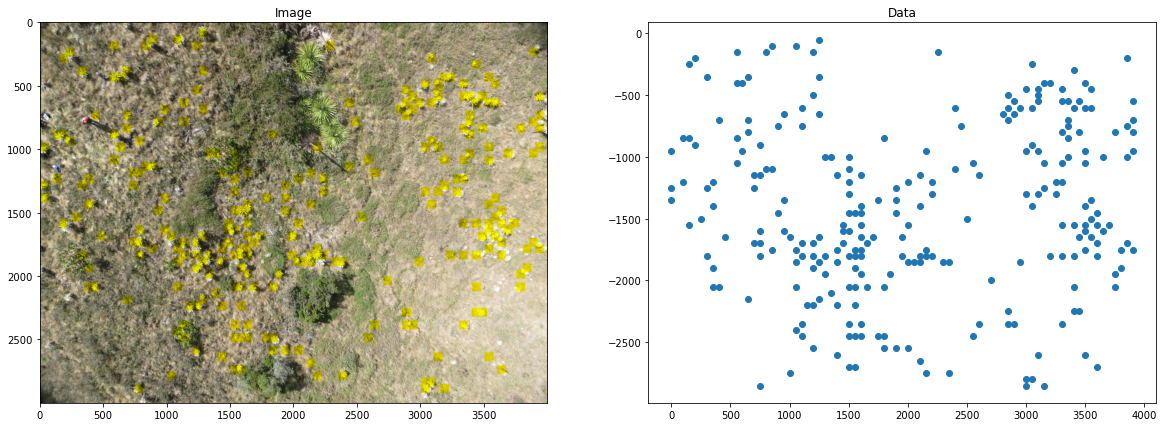


Una vez calculada la cantidad total de frilejones en la imagen, debe hacer el cálculo de la densidad poblacional. Se recomienda el uso de un GMM o puede aplicar algún análisis, heurística que identifique los grupos de frilejosnes en la imagen y la densidad en cada grupo.

Se intentó entrenar un modelo GMM con un dataset de 14700 columnas, pero los requerimientos computacionales eran excesivos. Se aplicó PCA para reducir la dimensionalidad y permitir el entrenamiento. Posteriormente, se planea repetir el entrenamiento sin PCA en un equipo más potente. La generación de gráficos dependerá de los resultados de estos experimentos

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Aplicar PCA
pca = PCA()
pca.fit(CT_xn.T)

PCA()

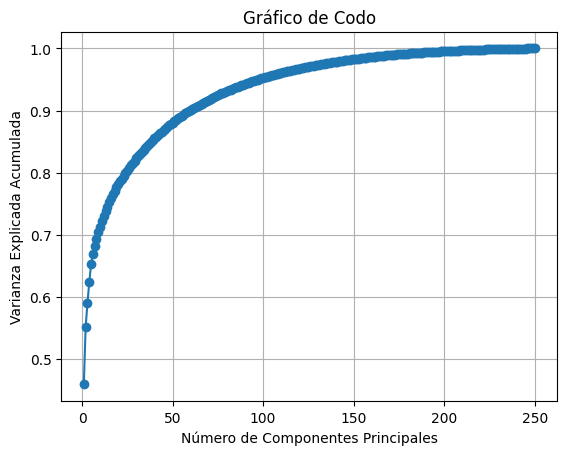

In [ ]:
# Obtener la varianza explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Graficar el gráfico de codo
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Gráfico de Codo')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(CT_xn.T)

In [ ]:
#
# Numero de componentes
#
n_components = np.arange(1, 10)

gaussianModels = [
    GaussianMixture(n, covariance_type="full", random_state=0).fit(X_reduced)
    for n in n_components
]

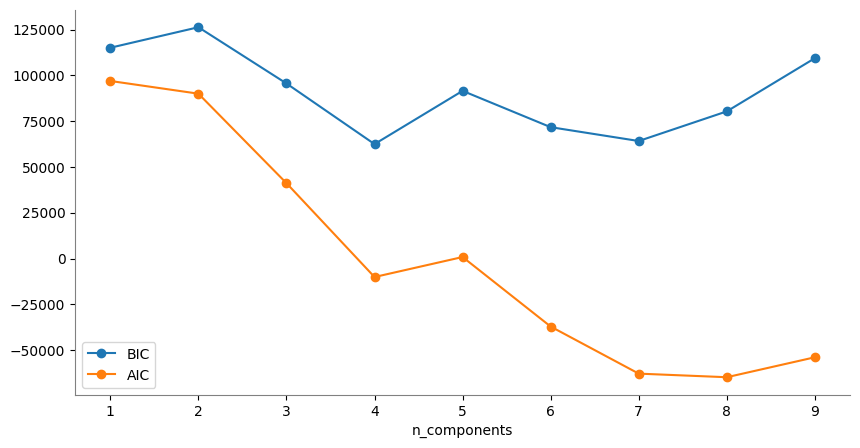

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(n_components, [model.bic(X_reduced) for model in gaussianModels], "o-", label="BIC")
plt.plot(n_components, [model.aic(X_reduced) for model in gaussianModels], "o-", label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

Interpretación del Gráfico y Selección del Número Óptimo de Componentes según AIC en un Modelo GMM
Entendiendo el Gráfico
El gráfico que presentas es una herramienta común en el modelado de mezclas gaussianas (GMM) para seleccionar el número óptimo de componentes. En este caso, las dos métricas principales que se están evaluando son el Criterio de Información Bayesiano (BIC) y el Criterio de Información de Akaike (AIC).

Eje X: Representa el número de componentes en el modelo GMM.
Eje Y: Representa el valor de las métricas BIC y AIC para cada número de componentes.
¿Qué nos dice el AIC?
El AIC es una estimación de la calidad relativa de los modelos estadísticos para un conjunto de datos dado. Un valor más bajo de AIC indica un mejor ajuste del modelo a los datos.

En el gráfico, el valor mínimo de AIC se alcanza en el componente número 4. Esto sugiere que, según el criterio de AIC, un modelo GMM con 4 componentes es el que mejor se ajusta a los datos, penalizando adecuadamente la complejidad del modelo.

¿Por qué el AIC sugiere 4 componentes?

- Ajuste vs. Complejidad: El AIC busca un equilibrio entre la capacidad del modelo para ajustar los datos (menor error) y su complejidad (menor número de parámetros).
- Penalización: A medida que aumenta el número de componentes, el AIC aplica una penalización más fuerte para evitar el sobreajuste.
- Mínimo Global: El punto más bajo en la curva de AIC indica el número de componentes donde esta penalización se equilibra con la mejora en el ajuste.

In [ ]:
#
# Numero de componentes
#
n_components = np.arange(1, 3)

gaussianModels = [
    GaussianMixture(n, covariance_type="full", random_state=0).fit(CT_xn.T)
    for n in n_components
]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(n_components, [model.bic(CT_xn.T) for model in gaussianModels], "o-", label="BIC")
plt.plot(n_components, [model.aic(CT_xn.T) for model in gaussianModels], "o-", label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [ ]:
print('oK')

oK
